Dataset shape: (959, 16)

First few rows:
   DaysLateLast30_MinMax  EngagementSurvey_Scaled  Tenure_Years_Scaled  \
0                    0.0                 0.896907             0.573643   
1                    0.0                 0.989691             0.062016   
2                    0.0                 0.489691             0.062016   
3                    0.0                 0.958763             0.844961   
4                    0.0                 1.000000             0.348837   

   Absences_MinMax  Salary_Scaled  EmpSatisfaction_Scaled  Age_Scaled  \
0         0.000000       0.085190                    1.00    0.288889   
1         0.842105       0.289777                    0.50    0.400000   
2         0.105263       0.097139                    0.50    0.022222   
3         0.736842       0.097315                    1.00    0.155556   
4         0.052632       0.028197                    0.75    0.066667   

   EmploymentStatus_Encoded  Sex_Encoded  MaritalDesc_Married  \
0        

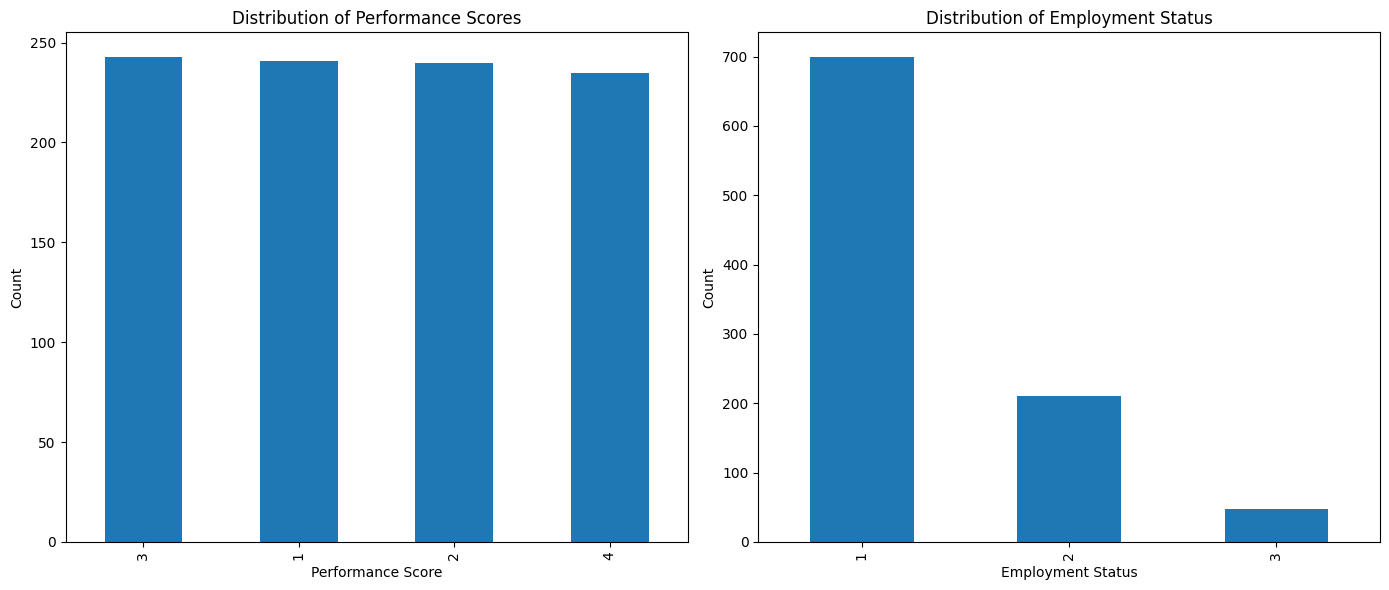

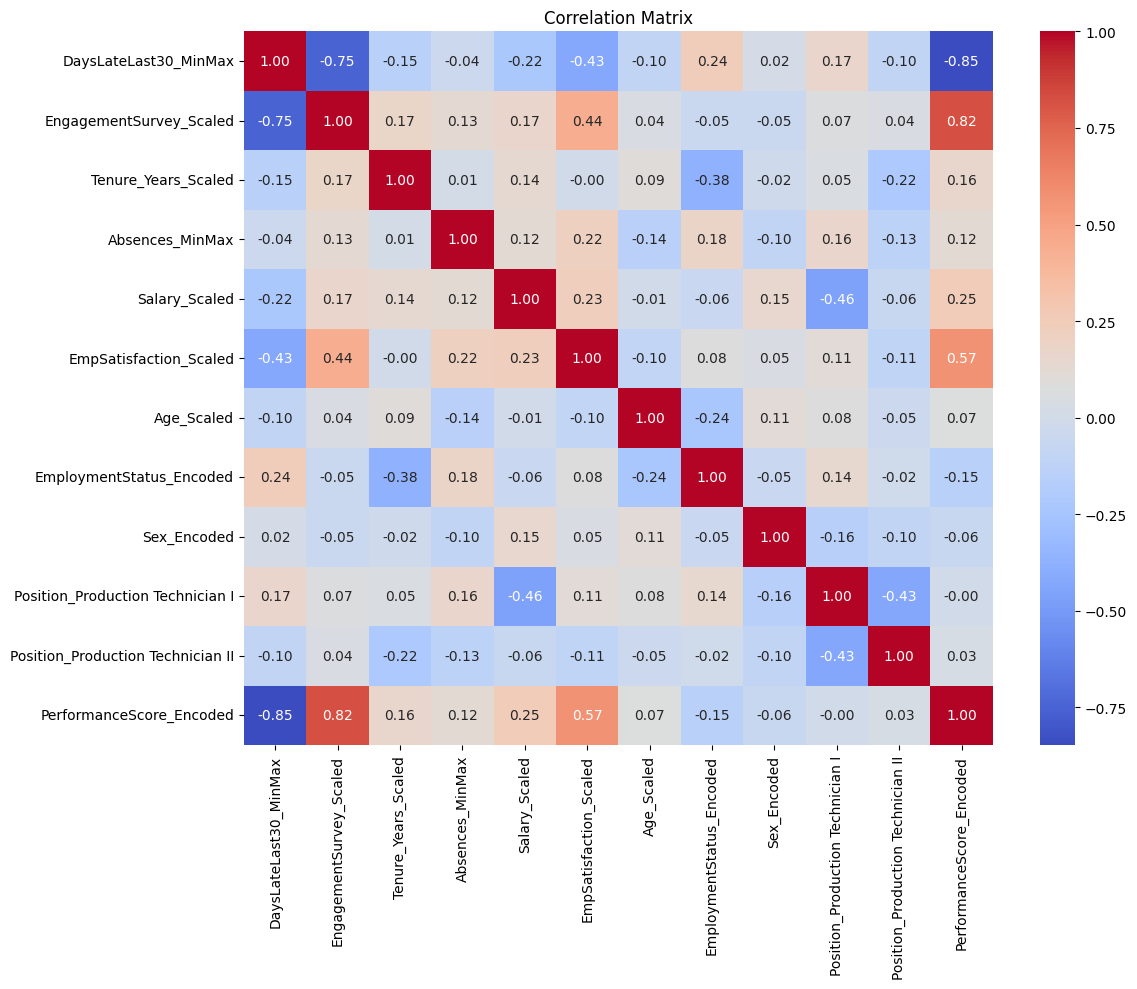


Numerical columns: ['DaysLateLast30_MinMax', 'EngagementSurvey_Scaled', 'Tenure_Years_Scaled', 'Absences_MinMax', 'Salary_Scaled', 'EmpSatisfaction_Scaled', 'Age_Scaled', 'EmploymentStatus_Encoded', 'Sex_Encoded', 'Position_Production Technician I', 'Position_Production Technician II']
Categorical columns: ['MaritalDesc_Married', 'RaceDesc_Black or African American', 'MaritalDesc_Single', 'RecruitmentSource_LinkedIn']

Training set shape: (767, 15), Testing set shape: (192, 15)
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best cross-validation score: 0.9491

Model Evaluation:
Accuracy: 0.9375

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        48
           2       0.98      1.00      0.99        48
           3       0.88      0.88      0

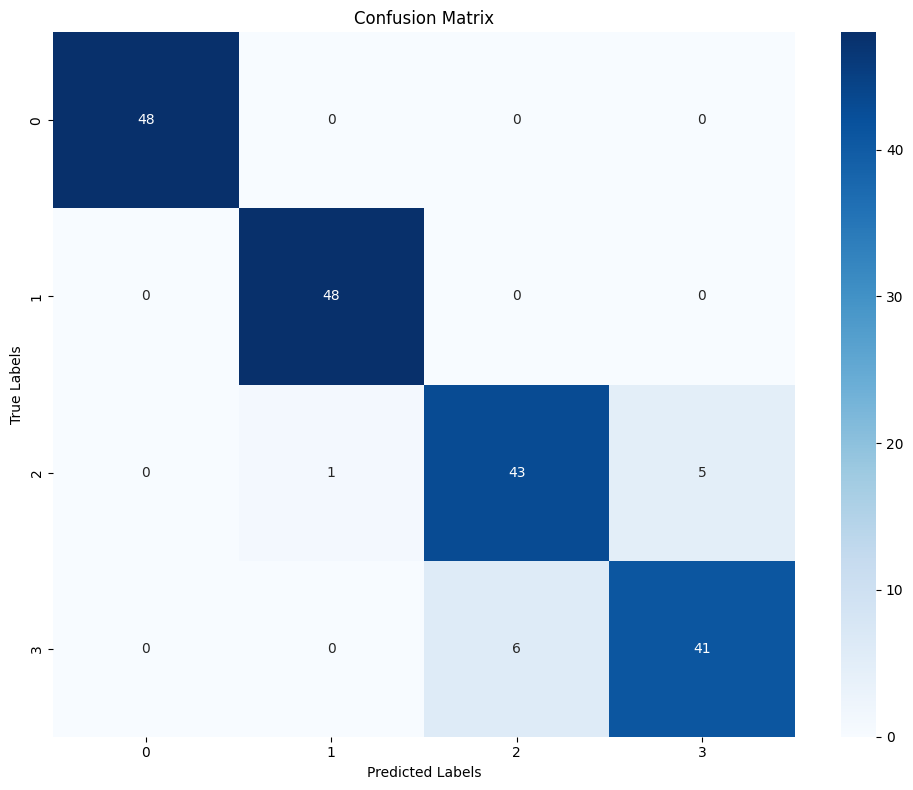


Model saved as 'rf_employee_model.pkl'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

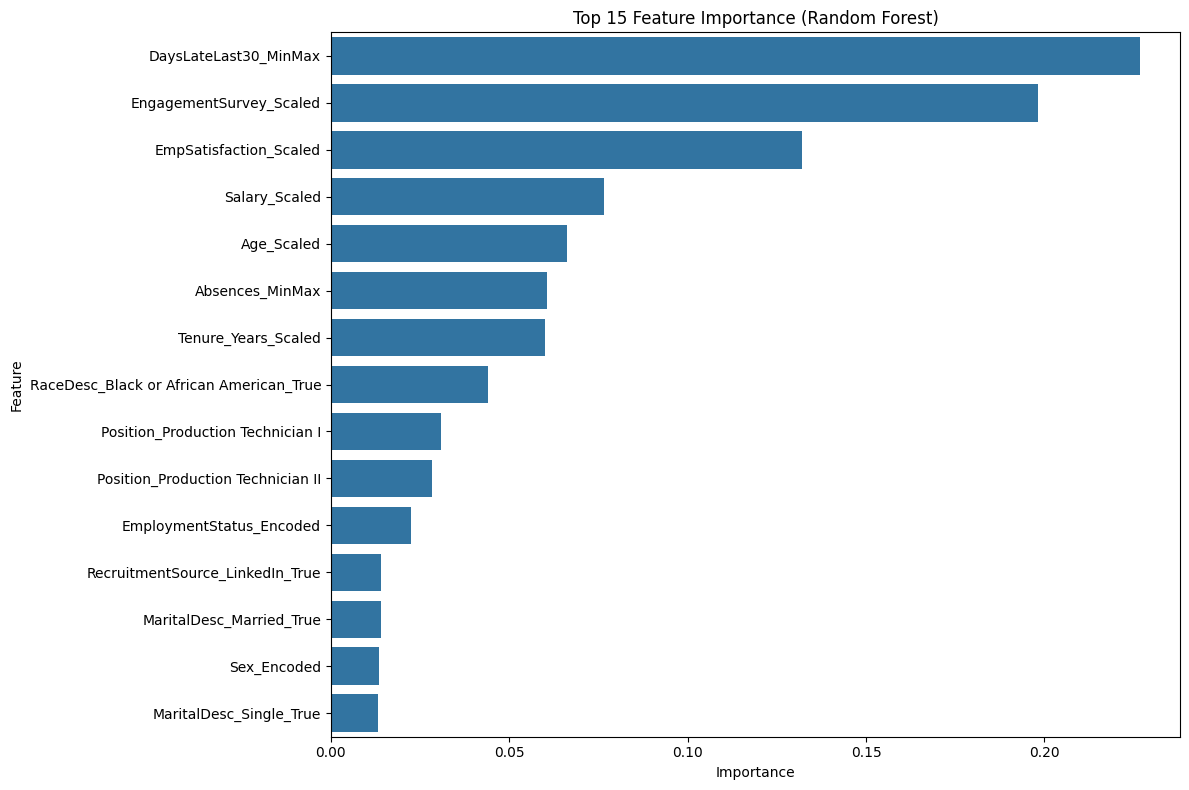

In [5]:
# Random Forest Training for Employee Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from google.colab import files
import io

'''# Upload the dataset in Google Colab
uploaded = files.upload()  # This will prompt you to upload your CSV file
file_name = list(uploaded.keys())[0]  # Get the filename of the uploaded file'''

# Read the dataset
df = pd.read_csv('employee_data_adasyn.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nSummary statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values count:")
print(df.isnull().sum())

# Convert string True/False to boolean for relevant columns
string_bool_columns = [col for col in df.columns if df[col].dtype == 'object' and
                       set(df[col].unique()).issubset({"True", "False"})]
for col in string_bool_columns:
    df[col] = df[col].map({"True": True, "False": False})

# Visualize distribution of potential target variables
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Assuming PerformanceScore_Encoded is the target variable
df['PerformanceScore_Encoded'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Distribution of Performance Scores')
axes[0].set_xlabel('Performance Score')
axes[0].set_ylabel('Count')

# Employment Status distribution
df['EmploymentStatus_Encoded'].value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title('Distribution of Employment Status')
axes[1].set_xlabel('Employment Status')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Correlation analysis
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Define features and target variable - you can change the target as needed
# Using PerformanceScore_Encoded as the target here
X = df.drop('PerformanceScore_Encoded', axis=1)
y = df['PerformanceScore_Encoded']

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['bool', 'object']).columns.tolist()

print("\nNumerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set shape: {X_train.shape}, Testing set shape: {X_test.shape}")

# Create a Random Forest pipeline with preprocessing
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define hyperparameters for grid search
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

# Use the best model to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
print("\nModel Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix visualization
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

# Save the best model
import pickle
with open('rf_employee_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)
print("\nModel saved as 'rf_employee_model.pkl'")

# Download the model (in Colab)
files.download('rf_employee_model.pkl')

# Feature importance analysis
# Get the fitted preprocessor from the pipeline
fitted_preprocessor = best_model.named_steps['preprocessor']

# Extract feature names from the fitted transformers
feature_names = []
for name, transformer, columns in fitted_preprocessor.transformers_:
    if name == 'num':
        feature_names.extend(columns)
    elif name == 'cat':
        # Get the feature names from the fitted one-hot encoder
        feature_names.extend(transformer.get_feature_names_out(categorical_cols))

# Get feature importances
importances = best_model.named_steps['classifier'].feature_importances_

# Create DataFrame for visualization
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

Upload your CSV dataset first:


Saving employee_data_adasyn.csv to employee_data_adasyn (1).csv

Now upload your saved Random Forest model:


Saving rf_employee_model(8).pkl to rf_employee_model(8).pkl

Model loaded successfully!
Model type: <class 'sklearn.pipeline.Pipeline'>
Pipeline steps: dict_keys(['preprocessor', 'classifier'])
Random Forest n_estimators: 200
Random Forest max_depth: None
Random Forest min_samples_split: 5
Random Forest min_samples_leaf: 1
Training set size: 767 samples, 15 features
Test set size: 192 samples, 15 features

Class distribution:
Training set:
  Class 3: 25.29% (194 samples)
  Class 1: 25.16% (193 samples)
  Class 2: 25.03% (192 samples)
  Class 4: 24.51% (188 samples)
Test set:
  Class 3: 25.52% (49 samples)
  Class 2: 25.00% (48 samples)
  Class 1: 25.00% (48 samples)
  Class 4: 24.48% (47 samples)
COMPREHENSIVE OVERFITTING ANALYSIS

1. ACCURACY GAP ANALYSIS
Training Accuracy: 0.9974
Test Accuracy: 0.9375
Accuracy Gap (Δ): 0.0599

Detailed Per-Class Accuracy Analysis:
Class      Train Acc  Test Acc   Gap        Status    
--------------------------------------------------
1          1.00

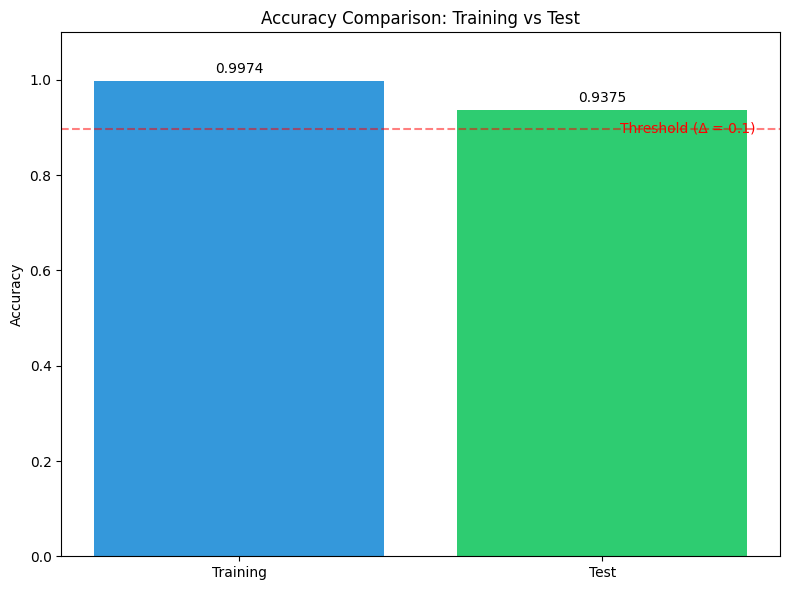


2. LEARNING CURVES ANALYSIS
Average gap between training and validation: 0.2350
Are curves converging? Yes
Are curves stable? No

Detailed Learning Curve Data:
Training Size   Train Score     Train Std       Val Score       Val Std         Gap            
------------------------------------------------------------------------------------------
58292           0.9184         0.0411         0.4661         0.1587         0.4523
117351          0.9490         0.0256         0.6079         0.1813         0.3411
176410          0.9487         0.0260         0.6987         0.1012         0.2500
234702          0.9575         0.0213         0.7185         0.1069         0.2390
293761          0.9666         0.0171         0.7029         0.0996         0.2637
352820          0.9713         0.0149         0.7425         0.0460         0.2288
411112          0.9757         0.0123         0.7727         0.0512         0.2031
470171          0.9785         0.0101         0.7852         0.0289    

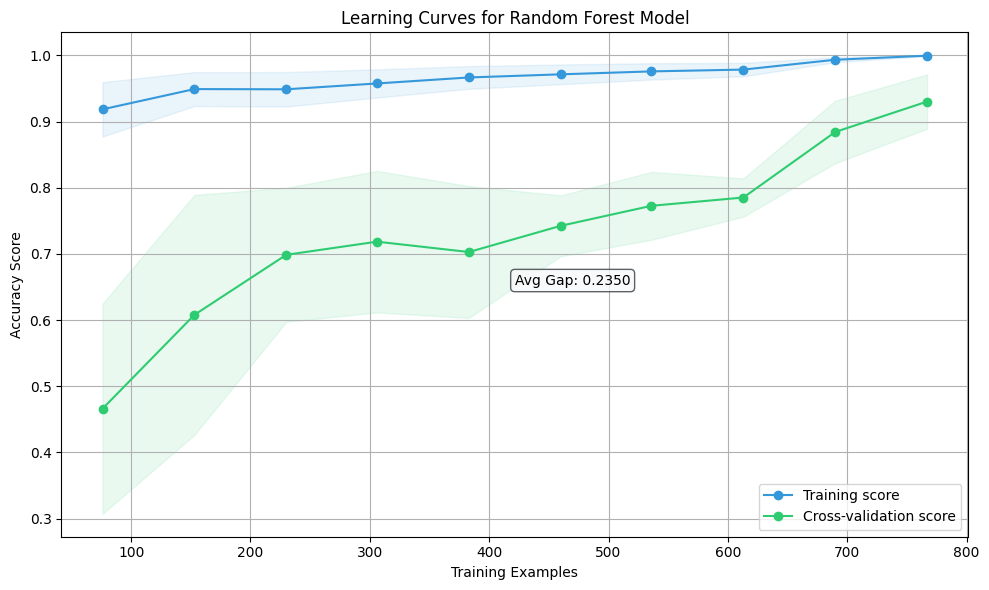


3. ROC ANALYSIS AND AUC COMPARISON
Training Set Macro-AUC: 1.0000
Test Set Macro-AUC: 0.9924
AUC Gap (Δ): 0.0076

Detailed Class-Specific ROC Analysis:
Class      Train AUC    Test AUC     AUC Gap      Train Threshold  Test Threshold   Status    
--------------------------------------------------------------------------------
0          1.0000      1.0000      0.0000      0.7594          0.7016          ✅ OK
1          1.0000      1.0000      0.0000      0.3375          0.7387          ✅ OK
2          1.0000      0.9827      0.0173      0.5995          0.3988          ✅ OK
3          1.0000      0.9868      0.0132      0.4492          0.3061          ✅ OK

Optimal Operating Points (Test Set):
Class 0: Threshold=0.7016, Sensitivity=1.0000, Specificity=1.0000
Class 1: Threshold=0.7387, Sensitivity=1.0000, Specificity=1.0000
Class 2: Threshold=0.3988, Sensitivity=0.9592, Specificity=0.9371
Class 3: Threshold=0.3061, Sensitivity=1.0000, Specificity=0.8897

✅ No significant overfitting det

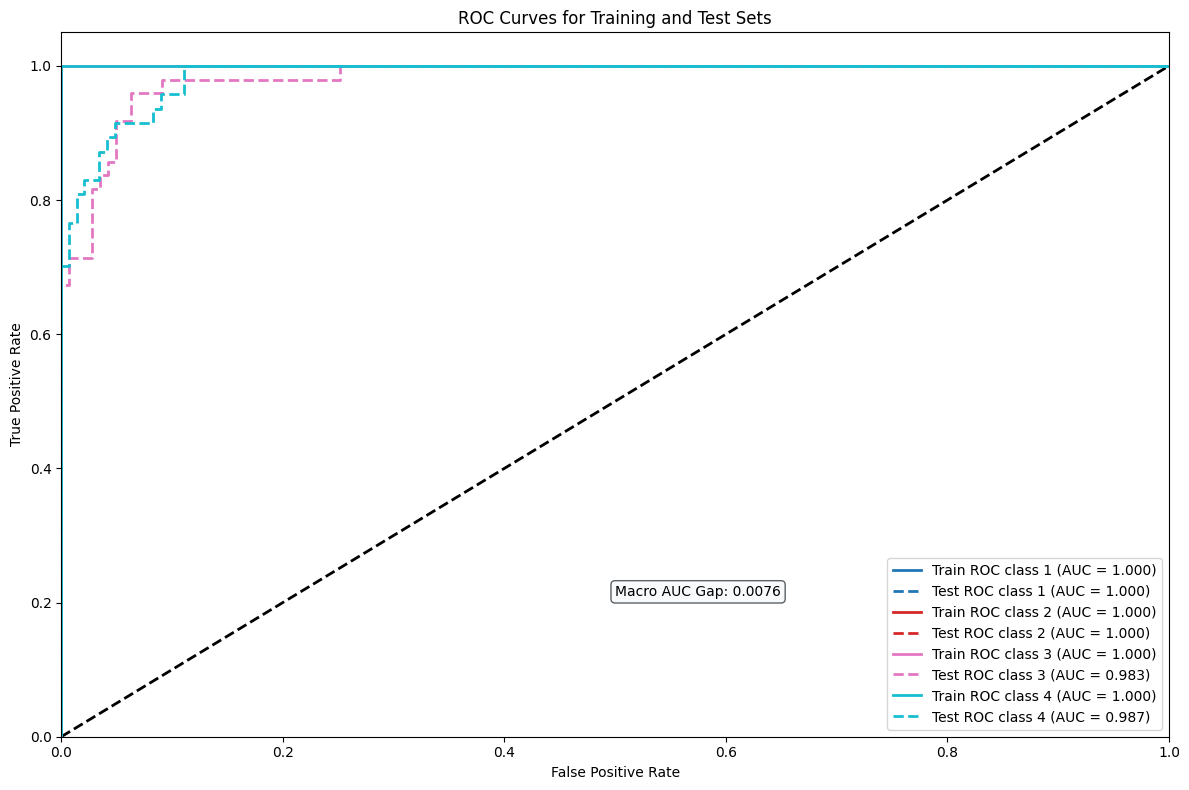

<Figure size 1000x600 with 0 Axes>

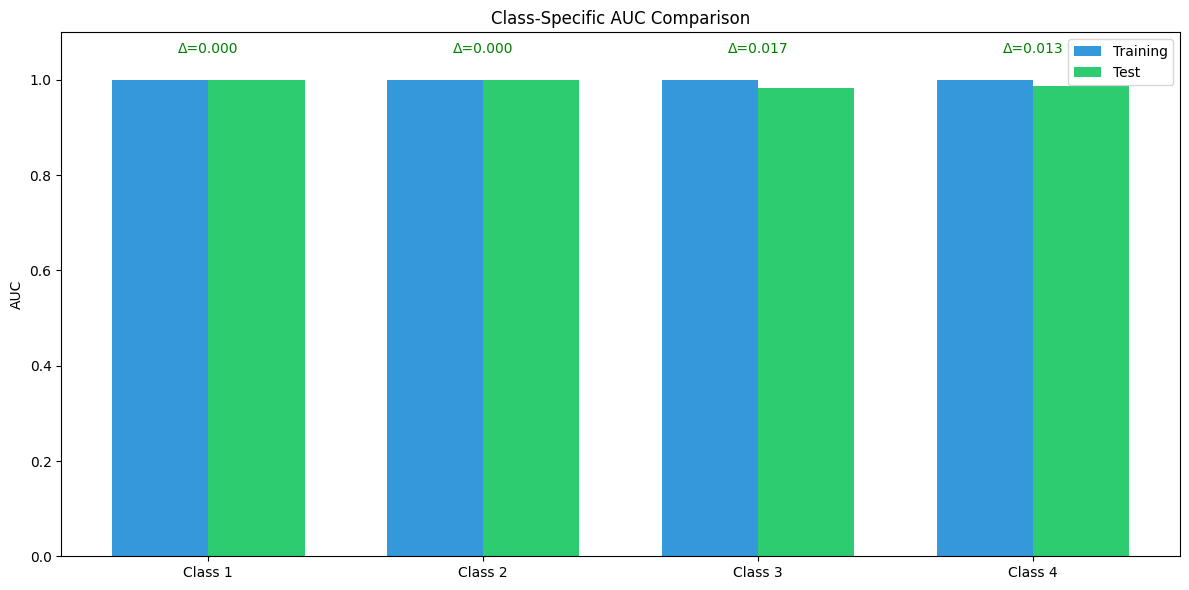


4. CLASS-SPECIFIC METRICS ANALYSIS

Detailed Class-specific Metrics:
Class      Metric     Train      Test       Diff       Status    
------------------------------------------------------------
1          Precision  1.0000    1.0000    0.0000    ✅ OK
           Recall     1.0000    1.0000    0.0000    ✅ OK
           F1-Score   1.0000    1.0000    0.0000    ✅ OK
------------------------------------------------------------
2          Precision  1.0000    0.9796    0.0204    ✅ OK
           Recall     0.9948    1.0000    -0.0052    ✅ OK
           F1-Score   0.9974    0.9897    0.0077    ✅ OK
------------------------------------------------------------
3          Precision  0.9898    0.8776    0.1122    ⚠️ Issue
           Recall     1.0000    0.8776    0.1224    ⚠️ Issue
           F1-Score   0.9949    0.8776    0.1173    ⚠️ Issue
------------------------------------------------------------
4          Precision  1.0000    0.8913    0.1087    ⚠️ Issue
           Recall     0.9947    0

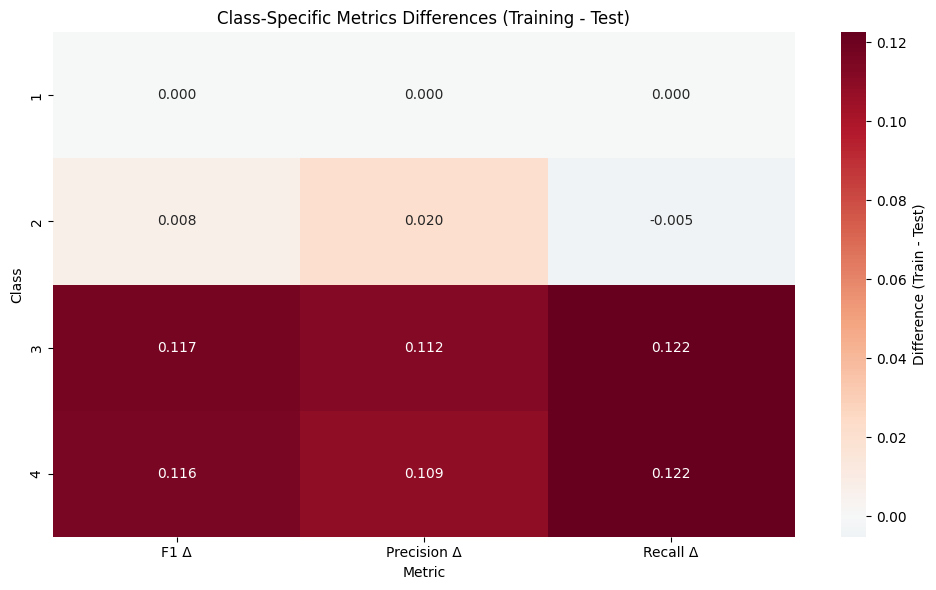


5. PREDICTION CONFIDENCE ANALYSIS

Confidence Statistics:
Statistic       Training        Test            Difference     
------------------------------------------------------------
Mean            0.9044        0.8322        0.0722
Median          0.9331        0.8707        0.0624
Min             0.4178        0.3988        0.0190
Max             1.0000        1.0000        0.0000
Std Dev         0.0914        0.1413        -0.0499

Confidence Distribution by Threshold:
Threshold  Training %      Test %          Difference      Status    
-----------------------------------------------------------------
≥ 0.5      99.74%         99.48%         0.26%           ✅ OK
≥ 0.6      99.35%         91.15%         8.20%           ✅ OK
≥ 0.7      95.96%         80.73%         15.23%           ⚠️ Issue
≥ 0.8      87.61%         63.02%         24.59%           ⚠️ Issue
≥ 0.9      61.80%         41.67%         20.13%           ⚠️ Issue
≥ 0.95     41.98%         28.12%         13.86%           ⚠️

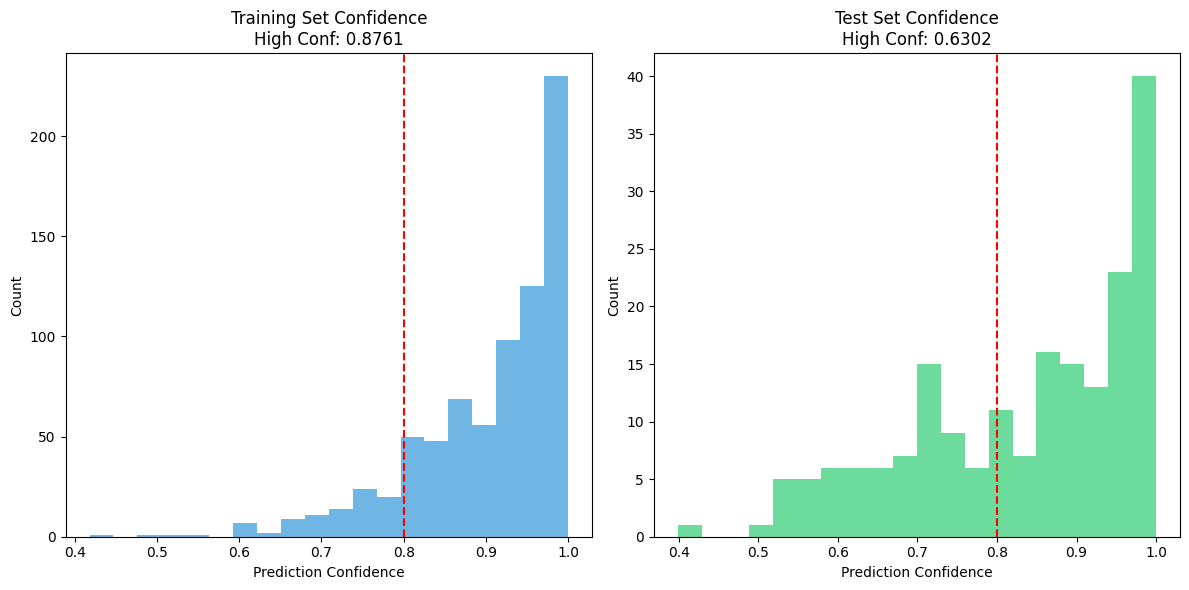

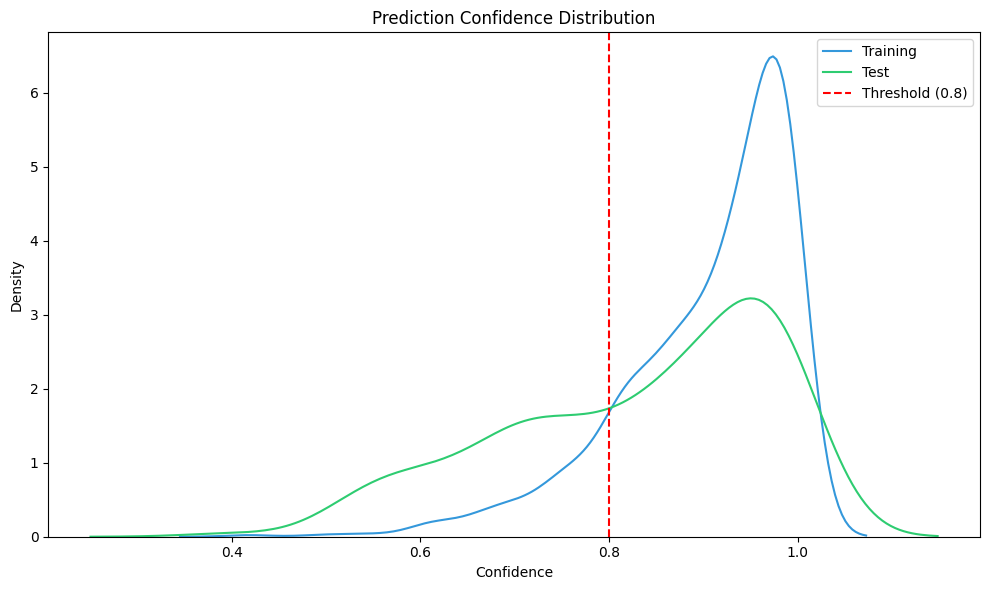

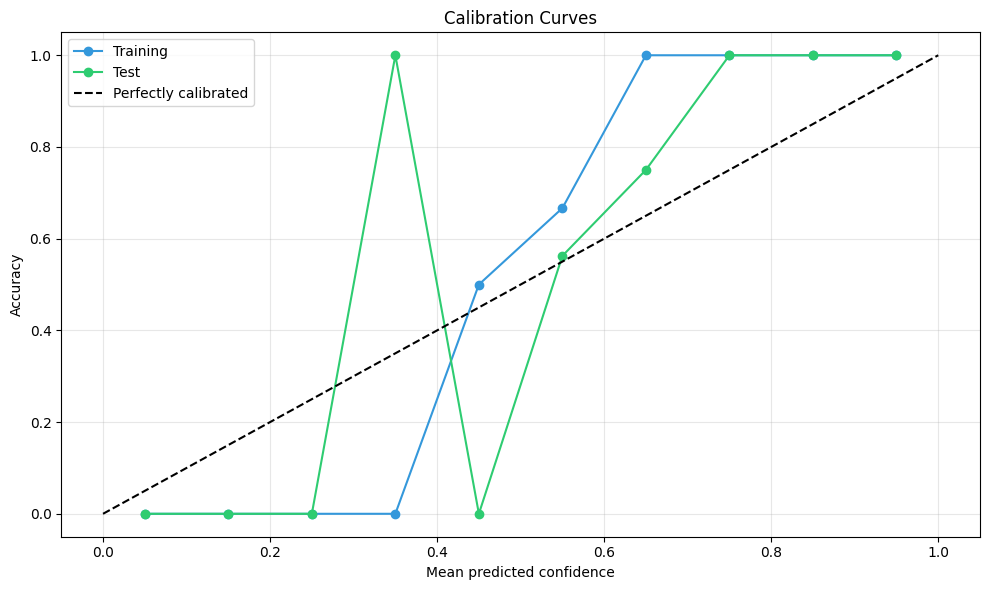


6. TREE COMPLEXITY PARAMETER ANALYSIS
Current max_depth parameter value: None
n_estimators: 200

Testing different max_depth values...
max_depth  Train Acc    Test Acc     Gap        Status    
------------------------------------------------------
5          0.9465       0.8750       0.0715    ✅ OK
10         0.9961       0.9271       0.0690    ✅ OK
15         0.9974       0.9375       0.0599    ✅ OK
20         0.9974       0.9375       0.0599    ✅ OK
25         0.9974       0.9375       0.0599    ✅ OK
30         0.9974       0.9375       0.0599    ✅ OK
None       0.9974       0.9375       0.0599    ✅ OK

Class-specific F1 scores at key max_depth values:

Current max_depth=None:
Class 1: Train F1=1.0000, Test F1=1.0000, Gap=0.0000
Class 2: Train F1=0.9974, Test F1=0.9897, Gap=0.0077
Class 3: Train F1=0.9949, Test F1=0.8776, Gap=0.1173
Class 4: Train F1=0.9973, Test F1=0.8817, Gap=0.1156

Minimum gap max_depth=15:
Class 1: Train F1=1.0000, Test F1=1.0000, Gap=0.0000
Class 2: Train F1=

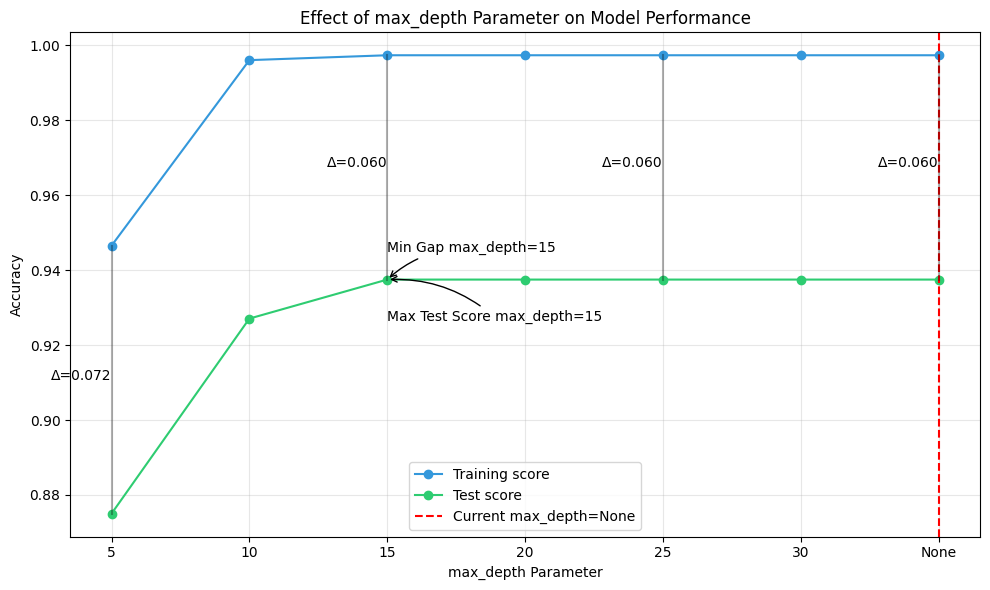

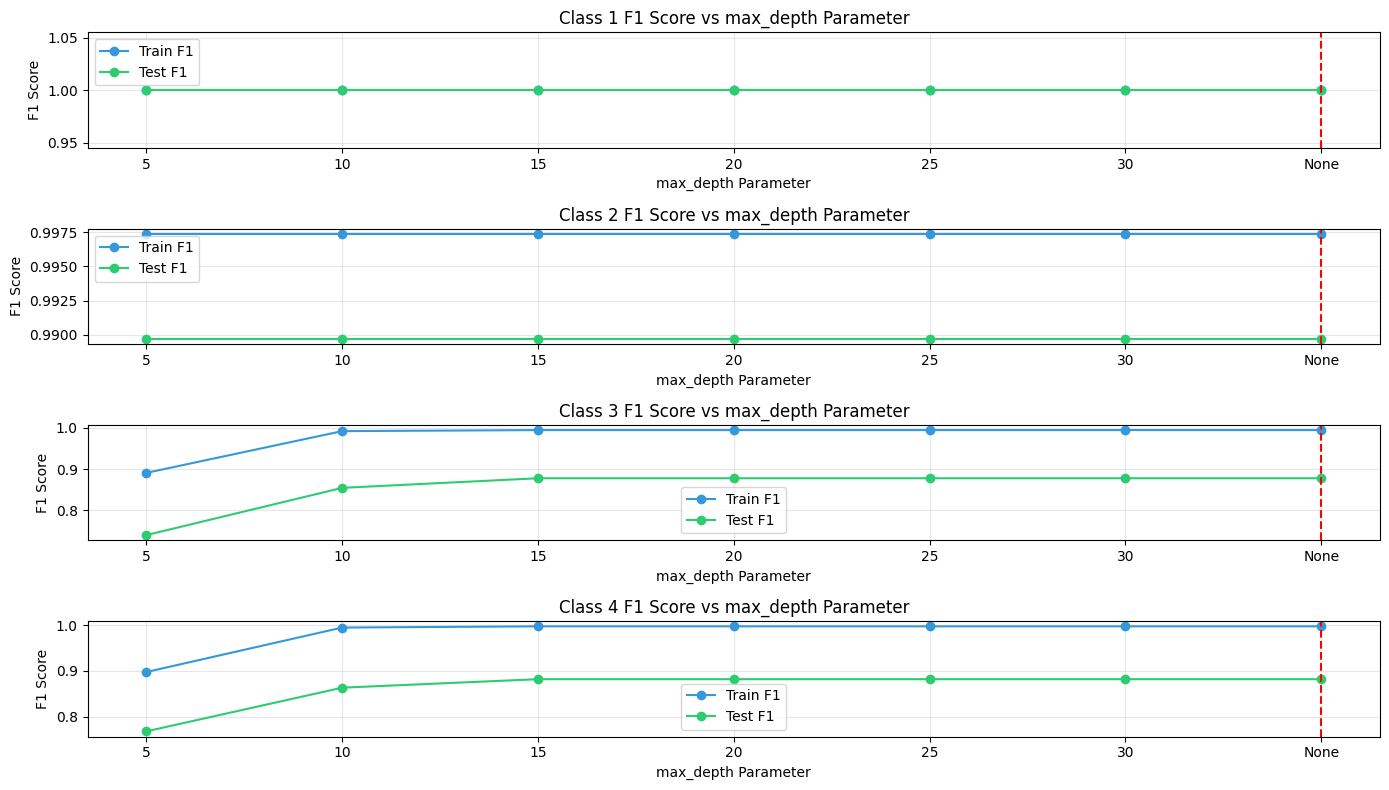


max_depth parameter recommendations:
- Minimum overfitting gap at max_depth=15
  Train accuracy: 0.9974, Test accuracy: 0.9375, Gap: 0.0599
- Maximum test score at max_depth=15
  Train accuracy: 0.9974, Test accuracy: 0.9375, Gap: 0.0599
- Current model uses max_depth=None
  Train accuracy: 0.9974, Test accuracy: 0.9375, Gap: 0.0599

⚠️ Recommendation: Change max_depth from None to 15 for better generalization and performance
   This would improve both the overfitting gap and test accuracy.


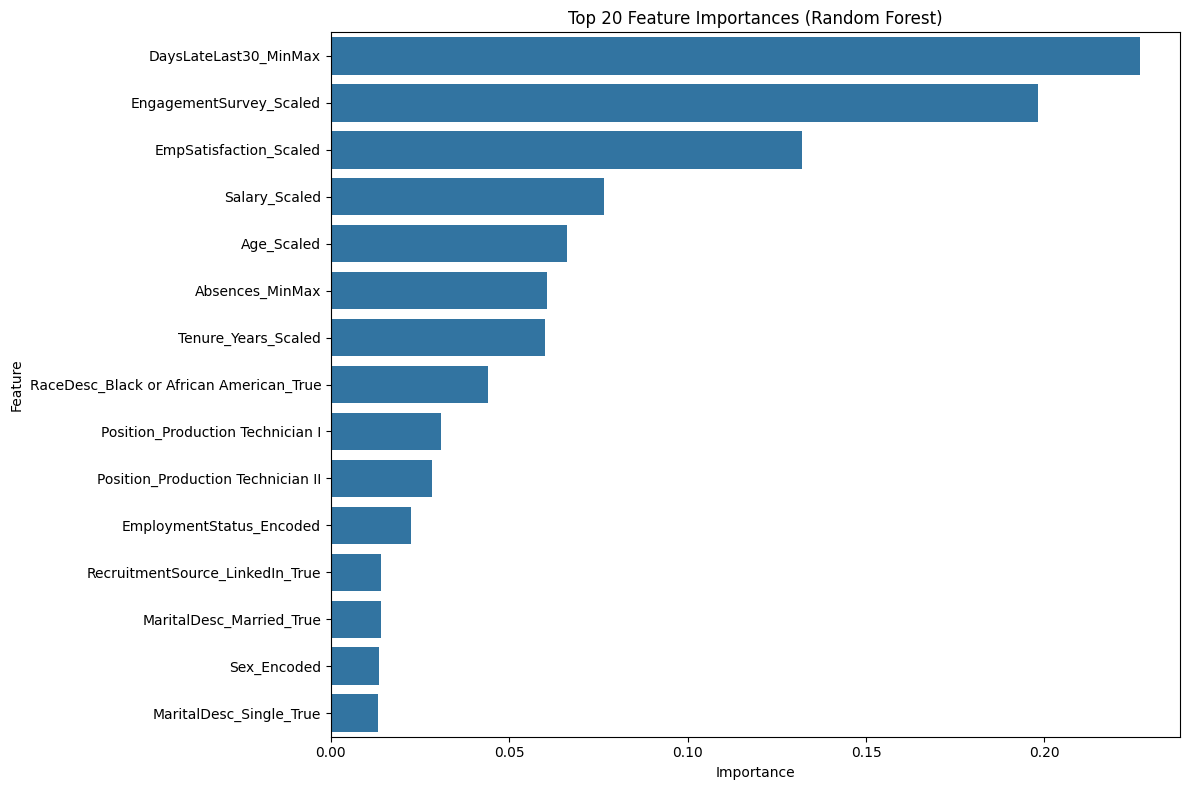


Feature Importance Analysis:
                                    Feature  Importance
0                     DaysLateLast30_MinMax    0.226683
1                   EngagementSurvey_Scaled    0.198088
5                    EmpSatisfaction_Scaled    0.131960
4                             Salary_Scaled    0.076693
6                                Age_Scaled    0.066070
3                           Absences_MinMax    0.060532
2                       Tenure_Years_Scaled    0.060121
12  RaceDesc_Black or African American_True    0.043908
9          Position_Production Technician I    0.030791
10        Position_Production Technician II    0.028222
7                  EmploymentStatus_Encoded    0.022318
14          RecruitmentSource_LinkedIn_True    0.014013
11                 MaritalDesc_Married_True    0.013998
8                               Sex_Encoded    0.013441
13                  MaritalDesc_Single_True    0.013162

7. CROSS-VALIDATION STABILITY ASSESSMENT
Cross-validation scores: [0.9322

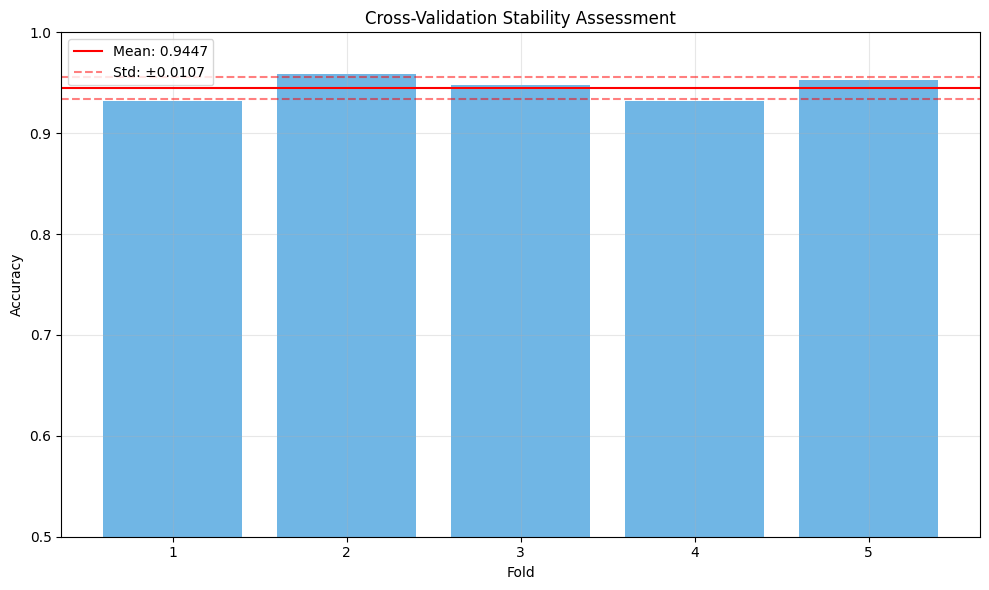

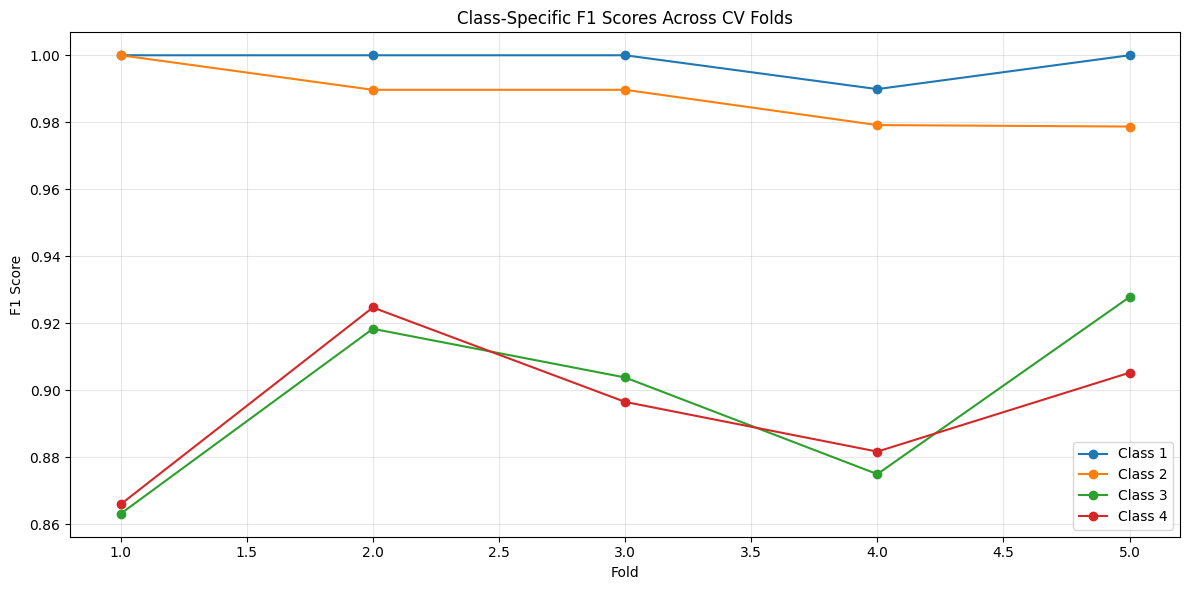


OVERFITTING ANALYSIS SUMMARY

Overfitting Indicators:
----------------------------------------------------------------------
Indicator                 Value      Status     Interpretation           
----------------------------------------------------------------------
Accuracy Gap              0.0599     ✅ OK       Acceptable gap           
Learning Curve Gap        0.2350     ⚠️ ISSUE   Poor generalization      
AUC Gap                   0.0076     ✅ OK       Consistent ranking       
Confidence Gap            0.2459     ⚠️ ISSUE   Overconfident on train   
Cross-validation Stability 0.0107     ✅ OK       Stable performance       
----------------------------------------------------------------------

Class-specific overfitting detected in: [np.int64(3), np.int64(4)]

⚠️ OVERALL ASSESSMENT: Mild overfitting detected
The model shows some signs of overfitting but may still be acceptable depending on the use case.
Consider adjusting tree complexity or using a simpler model if performan

In [6]:
# Overfitting Detection for Random Forest Employee Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, roc_curve, auc, precision_recall_fscore_support,
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pickle
from google.colab import files
import io
import warnings
warnings.filterwarnings('ignore')

# Upload the dataset and model in Google Colab
print("Upload your CSV dataset first:")
uploaded_data = files.upload()  # Upload the dataset
file_name = list(uploaded_data.keys())[0]

print("\nNow upload your saved Random Forest model:")
uploaded_model = files.upload()  # Upload the model
model_name = list(uploaded_model.keys())[0]

# Load the dataset
df = pd.read_csv(io.BytesIO(uploaded_data[file_name]))

# Convert string True/False to boolean for relevant columns
string_bool_columns = [col for col in df.columns if df[col].dtype == 'object' and
                       set(df[col].unique()).issubset({"True", "False"})]
for col in string_bool_columns:
    df[col] = df[col].map({"True": True, "False": False})

# Define features and target variable
X = df.drop('PerformanceScore_Encoded', axis=1)
y = df['PerformanceScore_Encoded']

# Load the trained model
with open(model_name, 'rb') as file:
    best_model = pickle.load(file)

print("\nModel loaded successfully!")
print(f"Model type: {type(best_model)}")
print(f"Pipeline steps: {best_model.named_steps.keys()}")
print(f"Random Forest n_estimators: {best_model.named_steps['classifier'].n_estimators}")
print(f"Random Forest max_depth: {best_model.named_steps['classifier'].max_depth}")
print(f"Random Forest min_samples_split: {best_model.named_steps['classifier'].min_samples_split}")
print(f"Random Forest min_samples_leaf: {best_model.named_steps['classifier'].min_samples_leaf}")

# Get the original data split that was used for training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set size: {X_test.shape[0]} samples, {X_test.shape[1]} features")

# Print class distribution
train_class_dist = pd.Series(y_train).value_counts(normalize=True)
test_class_dist = pd.Series(y_test).value_counts(normalize=True)
print("\nClass distribution:")
print("Training set:")
for cls, pct in train_class_dist.items():
    print(f"  Class {cls}: {pct:.2%} ({sum(y_train == cls)} samples)")
print("Test set:")
for cls, pct in test_class_dist.items():
    print(f"  Class {cls}: {pct:.2%} ({sum(y_test == cls)} samples)")

# ========================= 1. Comparing Metrics on Training and Test Sets =========================
def check_accuracy_gap():
    # Get predictions on training and test sets
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Calculate accuracies
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    accuracy_gap = train_accuracy - test_accuracy

    print("\n1. ACCURACY GAP ANALYSIS")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Accuracy Gap (Δ): {accuracy_gap:.4f}")

    # More detailed analysis
    print("\nDetailed Per-Class Accuracy Analysis:")
    classes = sorted(np.unique(y))

    print(f"{'Class':<10} {'Train Acc':<10} {'Test Acc':<10} {'Gap':<10} {'Status':<10}")
    print("-" * 50)

    for cls in classes:
        # Calculate per-class accuracy
        train_cls_acc = accuracy_score(y_train[y_train == cls], y_train_pred[y_train == cls])
        test_cls_acc = accuracy_score(y_test[y_test == cls], y_test_pred[y_test == cls])
        cls_gap = train_cls_acc - test_cls_acc

        status = "⚠️ Issue" if cls_gap > 0.1 else "✅ OK"
        print(f"{cls:<10} {train_cls_acc:.4f}     {test_cls_acc:.4f}     {cls_gap:.4f}     {status}")

    # Add confusion matrices
    print("\nTraining Set Confusion Matrix:")
    train_cm = confusion_matrix(y_train, y_train_pred)
    print(pd.DataFrame(train_cm, index=classes, columns=classes))

    print("\nTest Set Confusion Matrix:")
    test_cm = confusion_matrix(y_test, y_test_pred)
    print(pd.DataFrame(test_cm, index=classes, columns=classes))

    if accuracy_gap > 0.1:
        print("\n⚠️ Potential overfitting detected! (Δ > 0.1)")
        print(f"   The model performs {accuracy_gap:.2%} better on training data compared to test data.")
        print("   This suggests the model may have learned noise or patterns specific to the training data.")
    else:
        print("\n✅ No significant overfitting detected based on accuracy gap (Δ ≤ 0.1)")
        print(f"   The gap of {accuracy_gap:.2%} is within acceptable limits for generalization.")

    # Visualization of accuracy comparison
    plt.figure(figsize=(8, 6))
    bars = plt.bar(['Training', 'Test'], [train_accuracy, test_accuracy], color=['#3498db', '#2ecc71'])
    plt.ylim(0, 1.1)
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison: Training vs Test')

    # Add text labels above bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

    # Add a horizontal line for the threshold
    plt.axhline(y=train_accuracy - 0.1, color='r', linestyle='--', alpha=0.5)
    plt.text(1.05, train_accuracy - 0.1, 'Threshold (Δ = 0.1)', color='r', va='center')

    plt.tight_layout()
    plt.show()

    return train_accuracy, test_accuracy, accuracy_gap

# ========================= 2. Learning Curves Analysis =========================
def plot_learning_curves():
    print("\n2. LEARNING CURVES ANALYSIS")

    # Get the pipeline steps from the model
    preprocessor = best_model.named_steps['preprocessor']
    classifier = best_model.named_steps['classifier']

    # Create a new pipeline for learning curve evaluation
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Calculate learning curves
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes, train_scores, val_scores = learning_curve(
        pipeline, X, y, train_sizes=train_sizes, cv=5, scoring='accuracy', random_state=42, n_jobs=-1
    )

    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for validation set scores
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Calculate the gap between training and validation curves
    gap = train_mean - val_mean
    avg_gap = np.mean(gap)

    # Determine if the curves are converging
    converging = gap[-1] < gap[0]

    # Determine if curves are stable (low standard deviation in later points)
    late_std_train = np.mean(train_std[-3:])
    late_std_val = np.mean(val_std[-3:])
    stable = late_std_train < 0.03 and late_std_val < 0.03

    print(f"Average gap between training and validation: {avg_gap:.4f}")
    print(f"Are curves converging? {'Yes' if converging else 'No'}")
    print(f"Are curves stable? {'Yes' if stable else 'No'}")

    # Print detailed data for each point on the learning curve
    print("\nDetailed Learning Curve Data:")
    print(f"{'Training Size':<15} {'Train Score':<15} {'Train Std':<15} {'Val Score':<15} {'Val Std':<15} {'Gap':<15}")
    print("-" * 90)

    for i, size in enumerate(train_sizes):
        print(f"{int(size * X_train.shape[0]):<15} {train_mean[i]:.4f}         {train_std[i]:.4f}         {val_mean[i]:.4f}         {val_std[i]:.4f}         {gap[i]:.4f}")

    # Additional insights about what the curves indicate
    print("\nLearning Curve Interpretation:")
    if train_mean[-1] > 0.9 and avg_gap > 0.1:
        print("- High training score with significant gap indicates overfitting")
    elif train_mean[-1] < 0.8 and avg_gap < 0.05:
        print("- Low scores on both curves with small gap suggests underfitting")
    elif converging and stable:
        print("- Converging and stable curves indicate good generalization")

    print(f"- Starting gap (with {int(train_sizes[0] * X_train.shape[0])} samples): {gap[0]:.4f}")
    print(f"- Ending gap (with {int(train_sizes[-1] * X_train.shape[0])} samples): {gap[-1]:.4f}")

    if avg_gap > 0.1:
        print("\n⚠️ Potential overfitting detected! (avg gap > 0.1)")
        print("   The persistent gap between training and validation scores suggests")
        print("   the model is not generalizing well to unseen data.")
    else:
        print("\n✅ No significant overfitting detected based on learning curves (avg gap ≤ 0.1)")
        print("   The model seems to generalize well as the gap is acceptable.")

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='#3498db', label='Training score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='#3498db')

    plt.plot(train_sizes, val_mean, 'o-', color='#2ecc71', label='Cross-validation score')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='#2ecc71')

    plt.title('Learning Curves for Random Forest Model')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy Score')
    plt.grid(True)
    plt.legend(loc='best')

    # Add annotation for the gap
    plt.annotate(f'Avg Gap: {avg_gap:.4f}',
                xy=(0.5, 0.5), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="#f8f9fa", ec="#343a40", alpha=0.8))

    plt.tight_layout()
    plt.show()

    return avg_gap, converging, stable

# ========================= 3. ROC Analysis and AUC Comparison =========================
def perform_roc_analysis():
    print("\n3. ROC ANALYSIS AND AUC COMPARISON")

    # Get the number of classes
    n_classes = len(np.unique(y))

    # Binarize the output for multi-class ROC analysis
    y_train_bin = label_binarize(y_train, classes=sorted(np.unique(y)))
    y_test_bin = label_binarize(y_test, classes=sorted(np.unique(y)))

    # Get probability predictions
    y_train_score = best_model.predict_proba(X_train)
    y_test_score = best_model.predict_proba(X_test)

    # Calculate ROC curve and AUC for each class
    fpr_train = dict()
    tpr_train = dict()
    roc_auc_train = dict()

    fpr_test = dict()
    tpr_test = dict()
    roc_auc_test = dict()

    # Store optimal thresholds
    optimal_thresholds_train = dict()
    optimal_thresholds_test = dict()

    for i in range(n_classes):
        fpr_train[i], tpr_train[i], thresholds_train = roc_curve(y_train_bin[:, i], y_train_score[:, i])
        roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

        # Find optimal threshold (closest to top-left corner)
        optimal_idx_train = np.argmax(tpr_train[i] - fpr_train[i])
        optimal_thresholds_train[i] = thresholds_train[optimal_idx_train]

        fpr_test[i], tpr_test[i], thresholds_test = roc_curve(y_test_bin[:, i], y_test_score[:, i])
        roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

        # Find optimal threshold (closest to top-left corner)
        optimal_idx_test = np.argmax(tpr_test[i] - fpr_test[i])
        optimal_thresholds_test[i] = thresholds_test[optimal_idx_test]

    # Calculate macro-average AUC
    macro_auc_train = np.mean([roc_auc_train[i] for i in range(n_classes)])
    macro_auc_test = np.mean([roc_auc_test[i] for i in range(n_classes)])
    auc_gap = macro_auc_train - macro_auc_test

    print(f"Training Set Macro-AUC: {macro_auc_train:.4f}")
    print(f"Test Set Macro-AUC: {macro_auc_test:.4f}")
    print(f"AUC Gap (Δ): {auc_gap:.4f}")

    # Detailed class-specific ROC analysis
    print("\nDetailed Class-Specific ROC Analysis:")
    print(f"{'Class':<10} {'Train AUC':<12} {'Test AUC':<12} {'AUC Gap':<12} {'Train Threshold':<16} {'Test Threshold':<16} {'Status':<10}")
    print("-" * 80)

    for i in range(n_classes):
        class_gap = roc_auc_train[i] - roc_auc_test[i]
        status = "⚠️ Issue" if class_gap > 0.05 else "✅ OK"

        print(f"{i:<10} {roc_auc_train[i]:.4f}      {roc_auc_test[i]:.4f}      {class_gap:.4f}      {optimal_thresholds_train[i]:.4f}          {optimal_thresholds_test[i]:.4f}          {status}")

    # Calculate and print optimal sensitivity, specificity at chosen threshold
    print("\nOptimal Operating Points (Test Set):")
    for i in range(n_classes):
        # We need to use the class-specific thresholds
        # The optimal index was already found when calculating optimal_thresholds_test
        optimal_idx_test = np.argmax(tpr_test[i] - fpr_test[i])
        sensitivity = tpr_test[i][optimal_idx_test]
        specificity = 1 - fpr_test[i][optimal_idx_test]

        print(f"Class {i}: Threshold={optimal_thresholds_test[i]:.4f}, Sensitivity={sensitivity:.4f}, Specificity={specificity:.4f}")

    # Interpretation of results
    if auc_gap > 0.05:
        print("\n⚠️ Potential overfitting detected! (ΔAUC > 0.05)")
        print(f"   The model's discriminative ability is {auc_gap:.2%} better on training data")
        print("   compared to test data, suggesting it's learning patterns specific to the training set.")
    else:
        print("\n✅ No significant overfitting detected based on AUC gap (ΔAUC ≤ 0.05)")
        print(f"   The AUC gap of {auc_gap:.2%} suggests good generalization of the model's discriminative ability.")

    # Plot ROC curves
    plt.figure(figsize=(12, 8))

    # Plot macro-average ROC curve for training
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # Plot class-specific ROC curves
    colors = plt.cm.tab10(np.linspace(0, 1, n_classes))

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr_train[i], tpr_train[i], color=color, lw=2, linestyle='-',
                 label=f'Train ROC class {i+1} (AUC = {roc_auc_train[i]:.3f})')

        plt.plot(fpr_test[i], tpr_test[i], color=color, lw=2, linestyle='--',
                 label=f'Test ROC class {i+1} (AUC = {roc_auc_test[i]:.3f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Training and Test Sets')
    plt.legend(loc="lower right")

    # Add annotation for the gap
    plt.annotate(f'Macro AUC Gap: {auc_gap:.4f}',
                xy=(0.5, 0.2), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="#f8f9fa", ec="#343a40", alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Bar chart comparing class-specific AUCs
    plt.figure(figsize=(10, 6))

    class_labels = [f'Class {i+1}' for i in range(n_classes)]
    x = np.arange(len(class_labels))
    width = 0.35

    train_aucs = [roc_auc_train[i] for i in range(n_classes)]
    test_aucs = [roc_auc_test[i] for i in range(n_classes)]

    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, train_aucs, width, label='Training', color='#3498db')
    bars2 = ax.bar(x + width/2, test_aucs, width, label='Test', color='#2ecc71')

    ax.set_ylim(0, 1.1)
    ax.set_ylabel('AUC')
    ax.set_title('Class-Specific AUC Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(class_labels)
    ax.legend()

    # Add AUC gap annotations
    for i in range(n_classes):
        gap = train_aucs[i] - test_aucs[i]
        ax.annotate(f'Δ={gap:.3f}',
                   xy=(i, max(train_aucs[i], test_aucs[i]) + 0.05),
                   ha='center', va='bottom',
                   color='red' if gap > 0.05 else 'green')

    plt.tight_layout()
    plt.show()

    return macro_auc_train, macro_auc_test, auc_gap

# ========================= 4. Class-Specific Metrics Analysis =========================
def analyze_class_metrics():
    print("\n4. CLASS-SPECIFIC METRICS ANALYSIS")

    # Get predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Calculate metrics for training set
    precision_train, recall_train, f1_train, _ = precision_recall_fscore_support(y_train, y_train_pred, average=None)

    # Calculate metrics for test set
    precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(y_test, y_test_pred, average=None)

    # Calculate differences
    precision_diff = precision_train - precision_test
    recall_diff = recall_train - recall_test
    f1_diff = f1_train - f1_test

    # Calculate macro and weighted averages
    train_report = classification_report(y_train, y_train_pred, output_dict=True)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)

    # Check for overfitting in each class
    classes = sorted(np.unique(y))

    # Print class-specific metrics with more details
    print("\nDetailed Class-specific Metrics:")
    print(f"{'Class':<10} {'Metric':<10} {'Train':<10} {'Test':<10} {'Diff':<10} {'Status':<10}")
    print("-" * 60)

    # Define a function to determine metric status
    def get_status(diff, threshold=0.1):
        if diff > threshold:
            return "⚠️ Issue"
        elif diff < -threshold:
            return "⚠️ Lower"
        else:
            return "✅ OK"

    # Track problematic classes
    overfit_classes = []
    underperform_classes = []

    for i, cls in enumerate(classes):
        # Check precision
        p_status = get_status(precision_diff[i])
        print(f"{cls:<10} {'Precision':<10} {precision_train[i]:.4f}    {precision_test[i]:.4f}    {precision_diff[i]:.4f}    {p_status}")

        # Check recall
        r_status = get_status(recall_diff[i])
        print(f"{'':<10} {'Recall':<10} {recall_train[i]:.4f}    {recall_test[i]:.4f}    {recall_diff[i]:.4f}    {r_status}")

        # Check F1
        f1_status = get_status(f1_diff[i])
        print(f"{'':<10} {'F1-Score':<10} {f1_train[i]:.4f}    {f1_test[i]:.4f}    {f1_diff[i]:.4f}    {f1_status}")

        # Add separator between classes
        if i < len(classes) - 1:
            print("-" * 60)

        # Track if class has overfitting issues
        if abs(precision_diff[i]) > 0.1 or abs(recall_diff[i]) > 0.1 or abs(f1_diff[i]) > 0.1:
            if precision_diff[i] > 0.1 or recall_diff[i] > 0.1 or f1_diff[i] > 0.1:
                overfit_classes.append(cls)
            else:
                underperform_classes.append(cls)

    # Print aggregated metrics
    print("\nAggregated Metrics:")
    print(f"{'Average':<10} {'Metric':<10} {'Train':<10} {'Test':<10} {'Diff':<10} {'Status':<10}")
    print("-" * 60)

    # Macro averages
    macro_precision_diff = train_report['macro avg']['precision'] - test_report['macro avg']['precision']
    macro_recall_diff = train_report['macro avg']['recall'] - test_report['macro avg']['recall']
    macro_f1_diff = train_report['macro avg']['f1-score'] - test_report['macro avg']['f1-score']

    print(f"{'Macro':<10} {'Precision':<10} {train_report['macro avg']['precision']:.4f}    {test_report['macro avg']['precision']:.4f}    {macro_precision_diff:.4f}    {get_status(macro_precision_diff)}")
    print(f"{'':<10} {'Recall':<10} {train_report['macro avg']['recall']:.4f}    {test_report['macro avg']['recall']:.4f}    {macro_recall_diff:.4f}    {get_status(macro_recall_diff)}")
    print(f"{'':<10} {'F1-Score':<10} {train_report['macro avg']['f1-score']:.4f}    {test_report['macro avg']['f1-score']:.4f}    {macro_f1_diff:.4f}    {get_status(macro_f1_diff)}")

    # Weighted averages
    weighted_precision_diff = train_report['weighted avg']['precision'] - test_report['weighted avg']['precision']
    weighted_recall_diff = train_report['weighted avg']['recall'] - test_report['weighted avg']['recall']
    weighted_f1_diff = train_report['weighted avg']['f1-score'] - test_report['weighted avg']['f1-score']

    print("-" * 60)
    print(f"{'Weighted':<10} {'Precision':<10} {train_report['weighted avg']['precision']:.4f}    {test_report['weighted avg']['precision']:.4f}    {weighted_precision_diff:.4f}    {get_status(weighted_precision_diff)}")
    print(f"{'':<10} {'Recall':<10} {train_report['weighted avg']['recall']:.4f}    {test_report['weighted avg']['recall']:.4f}    {weighted_recall_diff:.4f}    {get_status(weighted_recall_diff)}")
    print(f"{'':<10} {'F1-Score':<10} {train_report['weighted avg']['f1-score']:.4f}    {test_report['weighted avg']['f1-score']:.4f}    {weighted_f1_diff:.4f}    {get_status(weighted_f1_diff)}")

    # Summary of findings
    if overfit_classes:
        print(f"\n⚠️ Potential class-specific overfitting detected in classes: {overfit_classes}")
        print("   This indicates the model has learned patterns specific to these classes in the training data")
        print("   that do not generalize well to the test set.")

    if underperform_classes:
        print(f"\n⚠️ Classes performing better on test than training: {underperform_classes}")
        print("   This unusual pattern could indicate sampling issues, data leakage, or class imbalance problems.")

    if not overfit_classes and not underperform_classes:
        print("\n✅ No significant class-specific overfitting detected")
        print("   All classes show consistent performance between training and test sets.")

    # Create a heatmap of metric differences
    metrics_diff = pd.DataFrame({
        'Class': classes,
        'Precision Δ': precision_diff,
        'Recall Δ': recall_diff,
        'F1 Δ': f1_diff
    })

    metrics_diff_pivot = metrics_diff.melt(id_vars=['Class'], var_name='Metric', value_name='Difference')
    pivot_table = metrics_diff_pivot.pivot(index='Class', columns='Metric', values='Difference')

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, cmap='RdBu_r', center=0, fmt='.3f', cbar_kws={'label': 'Difference (Train - Test)'})
    plt.title('Class-Specific Metrics Differences (Training - Test)')
    plt.tight_layout()
    plt.show()

    return metrics_diff, overfit_classes, underperform_classes

# ========================= 5. Prediction Confidence Analysis =========================
def analyze_prediction_confidence():
    print("\n5. PREDICTION CONFIDENCE ANALYSIS")

    # Get probability predictions
    y_train_proba = best_model.predict_proba(X_train)
    y_test_proba = best_model.predict_proba(X_test)

    # Get the max probability for each prediction (confidence)
    train_confidence = np.max(y_train_proba, axis=1)
    test_confidence = np.max(y_test_proba, axis=1)

    # Basic statistics
    print("\nConfidence Statistics:")
    print(f"{'Statistic':<15} {'Training':<15} {'Test':<15} {'Difference':<15}")
    print("-" * 60)

    # Mean confidence
    mean_train_conf = np.mean(train_confidence)
    mean_test_conf = np.mean(test_confidence)
    print(f"{'Mean':<15} {mean_train_conf:.4f}        {mean_test_conf:.4f}        {mean_train_conf - mean_test_conf:.4f}")

    # Median confidence
    median_train_conf = np.median(train_confidence)
    median_test_conf = np.median(test_confidence)
    print(f"{'Median':<15} {median_train_conf:.4f}        {median_test_conf:.4f}        {median_train_conf - median_test_conf:.4f}")

    # Min confidence
    min_train_conf = np.min(train_confidence)
    min_test_conf = np.min(test_confidence)
    print(f"{'Min':<15} {min_train_conf:.4f}        {min_test_conf:.4f}        {min_train_conf - min_test_conf:.4f}")

    # Max confidence
    max_train_conf = np.max(train_confidence)
    max_test_conf = np.max(test_confidence)
    print(f"{'Max':<15} {max_train_conf:.4f}        {max_test_conf:.4f}        {max_train_conf - max_test_conf:.4f}")

    # Standard deviation
    std_train_conf = np.std(train_confidence)
    std_test_conf = np.std(test_confidence)
    print(f"{'Std Dev':<15} {std_train_conf:.4f}        {std_test_conf:.4f}        {std_train_conf - std_test_conf:.4f}")

    # Calculate confidence thresholds
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

    print("\nConfidence Distribution by Threshold:")
    print(f"{'Threshold':<10} {'Training %':<15} {'Test %':<15} {'Difference':<15} {'Status':<10}")
    print("-" * 65)

    for threshold in thresholds:
        train_above = np.mean(train_confidence >= threshold)
        test_above = np.mean(test_confidence >= threshold)
        diff = train_above - test_above

        status = "⚠️ Issue" if diff > 0.1 else "✅ OK"

        print(f"≥ {threshold:<8} {train_above:.2%}         {test_above:.2%}         {diff:.2%}           {status}")

    # Calculate high confidence proportions
    high_conf_threshold = 0.8
    train_high_conf = np.mean(train_confidence >= high_conf_threshold)
    test_high_conf = np.mean(test_confidence >= high_conf_threshold)

    # Class-specific confidence analysis
    classes = sorted(np.unique(y))

    print("\nClass-Specific Confidence Analysis:")
    print(f"{'Class':<10} {'Train Mean':<15} {'Test Mean':<15} {'Difference':<15} {'Status':<10}")
    print("-" * 65)

    for cls in classes:
        # Get indices for this class
        train_cls_idx = (y_train == cls)
        test_cls_idx = (y_test == cls)

        # Calculate mean confidence for the class
        train_cls_conf = np.mean(train_confidence[train_cls_idx])
        test_cls_conf = np.mean(test_confidence[test_cls_idx])
        diff = train_cls_conf - test_cls_conf

        status = "⚠️ Issue" if diff > 0.1 else "✅ OK"

        print(f"{cls:<10} {train_cls_conf:.4f}        {test_cls_conf:.4f}        {diff:.4f}          {status}")

    # Decision quality analysis
    train_pred = best_model.predict(X_train)
    test_pred = best_model.predict(X_test)

    # Correct prediction confidence
    train_correct = (train_pred == y_train)
    test_correct = (test_pred == y_test)

    # Mean confidence for correct and incorrect predictions
    train_correct_conf = np.mean(train_confidence[train_correct])
    train_incorrect_conf = np.mean(train_confidence[~train_correct])
    test_correct_conf = np.mean(test_confidence[test_correct])
    test_incorrect_conf = np.mean(test_confidence[~test_correct])

    print("\nConfidence for Correct vs Incorrect Predictions:")
    print(f"{'Prediction':<12} {'Training':<15} {'Test':<15} {'Difference':<15}")
    print("-" * 57)
    print(f"{'Correct':<12} {train_correct_conf:.4f}        {test_correct_conf:.4f}        {train_correct_conf - test_correct_conf:.4f}")
    print(f"{'Incorrect':<12} {train_incorrect_conf:.4f}        {test_incorrect_conf:.4f}        {train_incorrect_conf - test_incorrect_conf:.4f}")
    print(f"{'Difference':<12} {train_correct_conf - train_incorrect_conf:.4f}        {test_correct_conf - test_incorrect_conf:.4f}")

    # Calibration analysis
    print("\nCalibration Analysis:")
    n_bins = 10
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

    # Training set calibration - using histogram approach instead of digitize
    train_bin_accuracies = np.zeros(n_bins)
    train_bin_counts = np.zeros(n_bins)

    # For each confidence score, find the appropriate bin and update counts
    for i in range(len(train_confidence)):
        # Find bin index using binary search
        bin_idx = min(int(train_confidence[i] * n_bins), n_bins - 1)  # Ensure index is within bounds
        train_bin_counts[bin_idx] += 1
        if train_pred[i] == y_train.iloc[i]:  # Use iloc for pandas Series
            train_bin_accuracies[bin_idx] += 1

    # Avoid division by zero
    train_bin_accuracies = np.divide(train_bin_accuracies, train_bin_counts,
                                     out=np.zeros_like(train_bin_accuracies),
                                     where=train_bin_counts != 0)

    # Test set calibration
    test_bin_accuracies = np.zeros(n_bins)
    test_bin_counts = np.zeros(n_bins)

    # For each confidence score, find the appropriate bin and update counts
    for i in range(len(test_confidence)):
        # Find bin index using binary search
        bin_idx = min(int(test_confidence[i] * n_bins), n_bins - 1)  # Ensure index is within bounds
        test_bin_counts[bin_idx] += 1
        if test_pred[i] == y_test.iloc[i]:  # Use iloc for pandas Series
            test_bin_accuracies[bin_idx] += 1

    # Avoid division by zero
    test_bin_accuracies = np.divide(test_bin_accuracies, test_bin_counts,
                                   out=np.zeros_like(test_bin_accuracies),
                                   where=test_bin_counts != 0)

    # Print calibration details
    print(f"{'Conf Range':<15} {'Train Acc':<12} {'Test Acc':<12} {'Train Count':<12} {'Test Count':<12}")
    print("-" * 63)

    for i in range(n_bins):
        bin_start = bin_edges[i]
        bin_end = bin_edges[i+1]
        train_acc_str = f"{train_bin_accuracies[i]:.4f}" if train_bin_counts[i] > 0 else "N/A"
        test_acc_str = f"{test_bin_accuracies[i]:.4f}" if test_bin_counts[i] > 0 else "N/A"
        print(f"{bin_start:.1f}-{bin_end:.1f}       {train_acc_str:<12} {test_acc_str:<12} {int(train_bin_counts[i]):<12} {int(test_bin_counts[i]):<12}")

    # Overall confidence gap assessment
    conf_gap = train_high_conf - test_high_conf

    if conf_gap > 0.1:
        print("\n⚠️ Potential overfitting detected! (confidence gap > 0.1)")
        print(f"   The model is {conf_gap:.2%} more confident on training data than test data,")
        print("   suggesting it may be too certain about patterns specific to the training set.")
    else:
        print("\n✅ No significant overfitting detected based on prediction confidence")
        print(f"   The confidence gap of {conf_gap:.2%} is within acceptable limits.")

    # Plot confidence histograms
    plt.figure(figsize=(12, 6))

    # Training set confidence histogram
    plt.subplot(1, 2, 1)
    plt.hist(train_confidence, bins=20, alpha=0.7, color='#3498db')
    plt.axvline(x=high_conf_threshold, color='r', linestyle='--')
    plt.title(f'Training Set Confidence\nHigh Conf: {train_high_conf:.4f}')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Count')

    # Test set confidence histogram
    plt.subplot(1, 2, 2)
    plt.hist(test_confidence, bins=20, alpha=0.7, color='#2ecc71')
    plt.axvline(x=high_conf_threshold, color='r', linestyle='--')
    plt.title(f'Test Set Confidence\nHigh Conf: {test_high_conf:.4f}')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

    # Compare overall confidence distributions
    plt.figure(figsize=(10, 6))
    sns.kdeplot(train_confidence, label='Training', color='#3498db')
    sns.kdeplot(test_confidence, label='Test', color='#2ecc71')
    plt.axvline(x=high_conf_threshold, color='r', linestyle='--', label=f'Threshold ({high_conf_threshold})')
    plt.title('Prediction Confidence Distribution')
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot calibration curves
    plt.figure(figsize=(10, 6))
    plt.plot(bin_centers, train_bin_accuracies, 'o-', color='#3498db', label='Training')
    plt.plot(bin_centers, test_bin_accuracies, 'o-', color='#2ecc71', label='Test')
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
    plt.xlabel('Mean predicted confidence')
    plt.ylabel('Accuracy')
    plt.title('Calibration Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return train_high_conf, test_high_conf, conf_gap

# ========================= 6. Tree Complexity Parameter Analysis =========================
def analyze_tree_complexity():
    print("\n6. TREE COMPLEXITY PARAMETER ANALYSIS")

    # Identify the classifier and preprocessor from the pipeline
    preprocessor = best_model.named_steps['preprocessor']
    best_max_depth = best_model.named_steps['classifier'].max_depth

    print(f"Current max_depth parameter value: {best_max_depth}")
    print(f"n_estimators: {best_model.named_steps['classifier'].n_estimators}")

    # Define a range of max_depth values to test
    if best_max_depth is None:
        max_depth_values = [5, 10, 15, 20, 25, 30, None]
    else:
        max_depth_values = [5, 10, 15, 20, 25, 30, None]
        if best_max_depth not in max_depth_values:
            max_depth_values.append(best_max_depth)
            max_depth_values.sort()
            # Move None to the end of the list
            if None in max_depth_values:
                max_depth_values.remove(None)
                max_depth_values.append(None)

    # Scores containers
    train_scores = []
    test_scores = []

    # Additional per-class metrics
    class_train_f1 = []
    class_test_f1 = []

    print("\nTesting different max_depth values...")
    print(f"{'max_depth':<10} {'Train Acc':<12} {'Test Acc':<12} {'Gap':<10} {'Status':<10}")
    print("-" * 54)

    for max_depth in max_depth_values:
        # Create a new Random Forest with the current max_depth value
        rf = RandomForestClassifier(
            n_estimators=best_model.named_steps['classifier'].n_estimators,
            max_depth=max_depth,
            min_samples_split=best_model.named_steps['classifier'].min_samples_split,
            min_samples_leaf=best_model.named_steps['classifier'].min_samples_leaf,
            random_state=42
        )

        # Create a pipeline with the same preprocessor
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', rf)
        ])

        # Fit the model
        pipeline.fit(X_train, y_train)

        # Get scores
        train_score = pipeline.score(X_train, y_train)
        test_score = pipeline.score(X_test, y_test)
        gap = train_score - test_score

        train_scores.append(train_score)
        test_scores.append(test_score)

        # Get class-specific metrics
        y_train_pred = pipeline.predict(X_train)
        y_test_pred = pipeline.predict(X_test)

        # Get per-class F1 scores
        _, _, f1_train, _ = precision_recall_fscore_support(y_train, y_train_pred, average=None)
        _, _, f1_test, _ = precision_recall_fscore_support(y_test, y_test_pred, average=None)

        class_train_f1.append(f1_train)
        class_test_f1.append(f1_test)

        # Print results for this max_depth value
        status = "⚠️ Issue" if gap > 0.1 else "✅ OK"
        print(f"{str(max_depth):<10} {train_score:.4f}       {test_score:.4f}       {gap:.4f}    {status}")

    # Convert max_depth values to strings for plotting
    max_depth_values_str = [str(depth) for depth in max_depth_values]

    # Find the index of the best max_depth value in our list
    best_max_depth_idx = max_depth_values.index(best_max_depth)

    # Calculate the gaps
    gaps = np.array(train_scores) - np.array(test_scores)

    # Find the max_depth with minimum gap
    min_gap_idx = np.argmin(gaps)
    min_gap_max_depth = max_depth_values[min_gap_idx]

    # Find the max_depth with maximum test score
    max_test_idx = np.argmax(test_scores)
    max_test_max_depth = max_depth_values[max_test_idx]

    # Print detailed class-specific analysis for best max_depth values
    print("\nClass-specific F1 scores at key max_depth values:")
    classes = sorted(np.unique(y))

    print(f"\nCurrent max_depth={best_max_depth}:")
    for i, cls in enumerate(classes):
        print(f"Class {cls}: Train F1={class_train_f1[best_max_depth_idx][i]:.4f}, Test F1={class_test_f1[best_max_depth_idx][i]:.4f}, Gap={class_train_f1[best_max_depth_idx][i] - class_test_f1[best_max_depth_idx][i]:.4f}")

    print(f"\nMinimum gap max_depth={min_gap_max_depth}:")
    for i, cls in enumerate(classes):
        print(f"Class {cls}: Train F1={class_train_f1[min_gap_idx][i]:.4f}, Test F1={class_test_f1[min_gap_idx][i]:.4f}, Gap={class_train_f1[min_gap_idx][i] - class_test_f1[min_gap_idx][i]:.4f}")

    print(f"\nMaximum test score max_depth={max_test_max_depth}:")
    for i, cls in enumerate(classes):
        print(f"Class {cls}: Train F1={class_train_f1[max_test_idx][i]:.4f}, Test F1={class_test_f1[max_test_idx][i]:.4f}, Gap={class_train_f1[max_test_idx][i] - class_test_f1[max_test_idx][i]:.4f}")

    # Plot the tree complexity parameter curve
    plt.figure(figsize=(10, 6))
    plt.plot(max_depth_values_str, train_scores, 'o-', color='#3498db', label='Training score')
    plt.plot(max_depth_values_str, test_scores, 'o-', color='#2ecc71', label='Test score')

    # Mark the current max_depth value
    plt.axvline(x=best_max_depth_idx, color='r', linestyle='--', label=f'Current max_depth={best_max_depth}')

    plt.title('Effect of max_depth Parameter on Model Performance')
    plt.xlabel('max_depth Parameter')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')

    # Add annotations
    plt.annotate(f'Min Gap max_depth={min_gap_max_depth}',
                xy=(max_depth_values_str[min_gap_idx], test_scores[min_gap_idx]),
                xytext=(0, 20), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

    plt.annotate(f'Max Test Score max_depth={max_test_max_depth}',
                xy=(max_depth_values_str[max_test_idx], test_scores[max_test_idx]),
                xytext=(0, -30), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

    # Add horizontal lines for each gap
    for i, (depth, gap) in enumerate(zip(max_depth_values_str, gaps)):
        if i % 2 == 0:  # Add for every other max_depth value to avoid clutter
            plt.plot([i, i], [test_scores[i], train_scores[i]], 'k-', alpha=0.3)
            plt.text(i, (test_scores[i] + train_scores[i])/2, f'Δ={gap:.3f}', ha='right')

    plt.tight_layout()
    plt.show()

    # Plot class-specific F1 scores for different max_depth values
    plt.figure(figsize=(14, 8))

    for i, cls in enumerate(classes):
        plt.subplot(len(classes), 1, i + 1)

        # Extract class-specific F1 scores
        cls_train_f1 = [f1[i] for f1 in class_train_f1]
        cls_test_f1 = [f1[i] for f1 in class_test_f1]

        plt.plot(max_depth_values_str, cls_train_f1, 'o-', color='#3498db', label='Train F1')
        plt.plot(max_depth_values_str, cls_test_f1, 'o-', color='#2ecc71', label='Test F1')

        plt.axvline(x=best_max_depth_idx, color='r', linestyle='--')
        plt.title(f'Class {cls} F1 Score vs max_depth Parameter')
        plt.xlabel('max_depth Parameter')
        plt.ylabel('F1 Score')
        plt.grid(True, alpha=0.3)
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Recommendations
    print(f"\nmax_depth parameter recommendations:")
    print(f"- Minimum overfitting gap at max_depth={min_gap_max_depth}")
    print(f"  Train accuracy: {train_scores[min_gap_idx]:.4f}, Test accuracy: {test_scores[min_gap_idx]:.4f}, Gap: {gaps[min_gap_idx]:.4f}")

    print(f"- Maximum test score at max_depth={max_test_max_depth}")
    print(f"  Train accuracy: {train_scores[max_test_idx]:.4f}, Test accuracy: {test_scores[max_test_idx]:.4f}, Gap: {gaps[max_test_idx]:.4f}")

    print(f"- Current model uses max_depth={best_max_depth}")
    print(f"  Train accuracy: {train_scores[best_max_depth_idx]:.4f}, Test accuracy: {test_scores[best_max_depth_idx]:.4f}, Gap: {gaps[best_max_depth_idx]:.4f}")

    if best_max_depth != min_gap_max_depth and best_max_depth != max_test_max_depth:
        if min_gap_max_depth == max_test_max_depth:
            print(f"\n⚠️ Recommendation: Change max_depth from {best_max_depth} to {min_gap_max_depth} for better generalization and performance")
            print("   This would improve both the overfitting gap and test accuracy.")
        else:
            print(f"\n⚠️ Recommendation: Consider changing max_depth from {best_max_depth} to either:")
            print(f"   - {min_gap_max_depth} for minimum overfitting (prioritizes generalization)")
            print(f"   - {max_test_max_depth} for maximum test performance (prioritizes accuracy)")
    else:
        print("\n✅ Current max_depth parameter is optimal")
        if best_max_depth == min_gap_max_depth:
            print("   Your model is already using the max_depth value with minimum overfitting.")
        else:
            print("   Your model is already using the max_depth value with maximum test performance.")

    # Feature importance analysis
    feature_importances = best_model.named_steps['classifier'].feature_importances_

    # Get the feature names
    feature_names = []
    for name, transformer, columns in best_model.named_steps['preprocessor'].transformers_:
        if name == 'num':
            feature_names.extend(columns)
        elif name == 'cat':
            feature_names.extend(transformer.get_feature_names_out(columns))

    if len(feature_importances) == len(feature_names):
        # Create a DataFrame for feature importance
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importances
        }).sort_values('Importance', ascending=False)

        # Plot feature importance
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
        plt.title('Top 20 Feature Importances (Random Forest)')
        plt.tight_layout()
        plt.show()

        print("\nFeature Importance Analysis:")
        print(feature_importance_df.head(20))
    else:
        print("\nWarning: Feature names and importance values do not match in length.")
        print(f"Feature importances length: {len(feature_importances)}, Feature names length: {len(feature_names)}")

    return train_scores, test_scores, max_depth_values, best_max_depth, min_gap_max_depth, max_test_max_depth

# ========================= 7. Cross-Validation Stability Assessment =========================
def assess_cv_stability():
    print("\n7. CROSS-VALIDATION STABILITY ASSESSMENT")

    # Define cross-validation
    n_splits = 5
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Get the classifier and preprocessor from the pipeline
    classifier = best_model.named_steps['classifier']
    preprocessor = best_model.named_steps['preprocessor']

    # Create a new pipeline for cross-validation
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Perform cross-validation for accuracy
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')

    # Calculate stability metrics
    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)
    cv_range = np.max(cv_scores) - np.min(cv_scores)
    cv_min = np.min(cv_scores)
    cv_max = np.max(cv_scores)

    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean accuracy: {cv_mean:.4f}")
    print(f"Standard deviation: {cv_std:.4f}")
    print(f"Range: {cv_range:.4f}")
    print(f"Minimum: {cv_min:.4f}")
    print(f"Maximum: {cv_max:.4f}")
    print(f"Coefficient of variation: {cv_std/cv_mean:.4f}")

    # Get more detailed metrics for each fold
    print("\nDetailed Fold-by-Fold Analysis:")
    print(f"{'Fold':<6} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'ROC AUC':<10}")
    print("-" * 56)

    fold_metrics = []

    for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
        y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]

        # Train the model
        pipeline.fit(X_fold_train, y_fold_train)

        # Get predictions
        y_fold_pred = pipeline.predict(X_fold_val)

        # Calculate metrics
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_fold_val, y_fold_pred, average='weighted')

        # Get probabilities for AUC
        if hasattr(pipeline, "predict_proba"):
            y_fold_proba = pipeline.predict_proba(X_fold_val)

            # For multiclass problems, we use weighted average of one-vs-rest AUCs
            if len(np.unique(y)) > 2:
                y_fold_bin = label_binarize(y_fold_val, classes=sorted(np.unique(y)))
                n_classes = y_fold_bin.shape[1]

                auc_scores = []
                for cls in range(n_classes):
                    if len(np.unique(y_fold_bin[:, cls])) > 1:  # Check if there are both positive and negative samples
                        auc_scores.append(roc_auc_score(y_fold_bin[:, cls], y_fold_proba[:, cls]))

                roc_auc = np.mean(auc_scores) if auc_scores else 'N/A'
            else:
                roc_auc = roc_auc_score(y_fold_val, y_fold_proba[:, 1])
        else:
            roc_auc = 'N/A'

        fold_metrics.append({
            'fold': i + 1,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc
        })

        print(f"{i+1:<6} {accuracy:.4f}     {precision:.4f}     {recall:.4f}     {f1:.4f}     {roc_auc if isinstance(roc_auc, str) else roc_auc:.4f}")

    # Calculate variation in metrics
    metrics_df = pd.DataFrame(fold_metrics)

    metrics_to_analyze = ['accuracy', 'precision', 'recall', 'f1']
    metrics_stats = {}

    for metric in metrics_to_analyze:
        metric_values = metrics_df[metric]
        metrics_stats[metric] = {
            'mean': np.mean(metric_values),
            'std': np.std(metric_values),
            'cv': np.std(metric_values) / np.mean(metric_values)
        }

    print("\nMetrics Variation Analysis:")
    print(f"{'Metric':<10} {'Mean':<10} {'Std Dev':<10} {'CV':<10} {'Status':<10}")
    print("-" * 50)

    for metric, stats in metrics_stats.items():
        status = "⚠️ Issue" if stats['cv'] > 0.05 else "✅ OK"
        print(f"{metric:<10} {stats['mean']:.4f}     {stats['std']:.4f}     {stats['cv']:.4f}     {status}")

    # Analyze class-specific stability
    print("\nClass-Specific Stability Analysis:")

    classes = sorted(np.unique(y))
    class_f1_scores = {}

    for cls in classes:
        class_f1_scores[cls] = []

    for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
        y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]

        # Train the model
        pipeline.fit(X_fold_train, y_fold_train)

        # Get predictions
        y_fold_pred = pipeline.predict(X_fold_val)

        # Calculate class-specific F1 scores
        _, _, f1_scores, _ = precision_recall_fscore_support(y_fold_val, y_fold_pred, average=None)

        for j, cls in enumerate(classes):
            if j < len(f1_scores):
                class_f1_scores[cls].append(f1_scores[j])

    print(f"{'Class':<10} {'Mean F1':<10} {'Std Dev':<10} {'CV':<10} {'Status':<10}")
    print("-" * 50)

    unstable_classes = []

    for cls, scores in class_f1_scores.items():
        mean_f1 = np.mean(scores)
        std_f1 = np.std(scores)
        cv_f1 = std_f1 / mean_f1 if mean_f1 > 0 else float('inf')

        status = "⚠️ Issue" if cv_f1 > 0.1 else "✅ OK"
        if cv_f1 > 0.1:
            unstable_classes.append(cls)

        print(f"{cls:<10} {mean_f1:.4f}     {std_f1:.4f}     {cv_f1:.4f}     {status}")

    # Evaluate stability
    if cv_std > 0.05:
        print("\n⚠️ High variance across folds detected (std > 0.05)")
        print(f"   This suggests the model's performance is sensitive to the specific data split.")
        print("   Consider using techniques like ensembling or more regularization.")
    else:
        print("\n✅ Model is stable across cross-validation folds (std ≤ 0.05)")
        print("   The model consistently performs well across different data splits.")

    if unstable_classes:
        print(f"\n⚠️ Unstable class performance detected for classes: {unstable_classes}")
        print("   These classes show high variability in F1 scores across folds.")
        print("   Consider collecting more data for these classes or applying class-specific techniques.")

    # Visualize the cross-validation results
    plt.figure(figsize=(10, 6))

    # Plot each fold score
    plt.bar(range(1, len(cv_scores) + 1), cv_scores, color='#3498db', alpha=0.7)

    # Add mean line
    plt.axhline(y=cv_mean, color='r', linestyle='-', label=f'Mean: {cv_mean:.4f}')

    # Add std bounds
    plt.axhline(y=cv_mean + cv_std, color='r', linestyle='--', alpha=0.5,
                label=f'Std: ±{cv_std:.4f}')
    plt.axhline(y=cv_mean - cv_std, color='r', linestyle='--', alpha=0.5)

    plt.title('Cross-Validation Stability Assessment')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, len(cv_scores) + 1))
    plt.ylim(0.5, 1.0)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot class-specific performance across folds
    plt.figure(figsize=(12, 6))

    for i, (cls, scores) in enumerate(class_f1_scores.items()):
        plt.plot(range(1, n_splits + 1), scores, 'o-', label=f'Class {cls}')

    plt.title('Class-Specific F1 Scores Across CV Folds')
    plt.xlabel('Fold')
    plt.ylabel('F1 Score')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return cv_mean, cv_std, cv_range, unstable_classes

# ========================= MAIN EXECUTION FUNCTION =========================
def check_overfitting():
    """Perform comprehensive overfitting analysis on the model"""
    print("=" * 80)
    print("COMPREHENSIVE OVERFITTING ANALYSIS")
    print("=" * 80)

    # Run all analyses
    train_acc, test_acc, acc_gap = check_accuracy_gap()
    avg_gap, converging, stable = plot_learning_curves()
    macro_auc_train, macro_auc_test, auc_gap = perform_roc_analysis()
    metrics_diff, overfit_classes, underperform_classes = analyze_class_metrics()
    train_high_conf, test_high_conf, conf_gap = analyze_prediction_confidence()
    train_scores, test_scores, max_depth_values, best_max_depth, min_gap_max_depth, max_test_max_depth = analyze_tree_complexity()
    cv_mean, cv_std, cv_range, unstable_classes = assess_cv_stability()

    # Generate a summary report
    print("\n" + "=" * 80)
    print("OVERFITTING ANALYSIS SUMMARY")
    print("=" * 80)

    overfitting_indicators = [
        ("Accuracy Gap", acc_gap > 0.1, acc_gap),
        ("Learning Curve Gap", avg_gap > 0.1, avg_gap),
        ("AUC Gap", auc_gap > 0.05, auc_gap),
        ("Confidence Gap", conf_gap > 0.1, conf_gap),
        ("Cross-validation Stability", cv_std > 0.05, cv_std)
    ]

    # Count how many indicators suggest overfitting
    overfitting_count = sum(1 for _, is_overfitting, _ in overfitting_indicators if is_overfitting)

    # Print summary table
    print("\nOverfitting Indicators:")
    print("-" * 70)
    print(f"{'Indicator':<25} {'Value':<10} {'Status':<10} {'Interpretation':<25}")
    print("-" * 70)

    for indicator, is_overfitting, value in overfitting_indicators:
        status = "⚠️ ISSUE" if is_overfitting else "✅ OK"

        # Add interpretations for each indicator
        if indicator == "Accuracy Gap":
            interp = "Significant gap" if is_overfitting else "Acceptable gap"
        elif indicator == "Learning Curve Gap":
            interp = "Poor generalization" if is_overfitting else "Good generalization"
        elif indicator == "AUC Gap":
            interp = "Inconsistent ranking" if is_overfitting else "Consistent ranking"
        elif indicator == "Confidence Gap":
            interp = "Overconfident on train" if is_overfitting else "Well-calibrated"
        elif indicator == "Cross-validation Stability":
            interp = "High data sensitivity" if is_overfitting else "Stable performance"

        print(f"{indicator:<25} {value:.4f}     {status:<10} {interp:<25}")

    print("-" * 70)

    # Class-specific issues
    if overfit_classes:
        print(f"\nClass-specific overfitting detected in: {overfit_classes}")

    if underperform_classes:
        print(f"Classes performing better on test than training: {underperform_classes}")

    if unstable_classes:
        print(f"Classes with unstable CV performance: {unstable_classes}")

    # Overall assessment with more detail
    if overfitting_count == 0:
        print("\n🎉 OVERALL ASSESSMENT: No significant overfitting detected")
        print("The model generalizes well to unseen data with consistent performance across metrics.")
        print(f"Training accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}")
        print(f"Current max_depth value: {best_max_depth} is appropriate for this model.")
    elif overfitting_count == 1:
        print("\n⚠️ OVERALL ASSESSMENT: Slight overfitting detected")
        print("The model shows a minor sign of overfitting but is generally acceptable.")
        print(f"The main concern is in the {next(indicator for indicator, is_overfitting, _ in overfitting_indicators if is_overfitting)} metric.")
    elif overfitting_count <= 2:
        print("\n⚠️ OVERALL ASSESSMENT: Mild overfitting detected")
        print("The model shows some signs of overfitting but may still be acceptable depending on the use case.")
        print("Consider adjusting tree complexity or using a simpler model if performance in production is a concern.")
    else:
        print("\n❌ OVERALL ASSESSMENT: Significant overfitting detected")
        print("The model is likely overfitting the training data and may not generalize well to new data.")
        print("Immediate action is recommended to address these issues before deploying the model.")

    # Recommendations with more detail
    print("\nDETAILED RECOMMENDATIONS:")

    if overfitting_count > 0:
        print("\n1. Tree complexity parameter adjustment:")
        print(f"   - Current max_depth: {best_max_depth}")
        print(f"   - Recommended max_depth for minimizing overfitting: {min_gap_max_depth}")
        print(f"   - Recommended max_depth for maximizing test performance: {max_test_max_depth}")

        if best_max_depth is None or (min_gap_max_depth is not None and min_gap_max_depth < best_max_depth):
            print(f"   → Consider decreasing max_depth from {best_max_depth} to {min_gap_max_depth} to reduce model complexity")
            print(f"     This would change the gap from {acc_gap:.4f} to approximately {min(gaps for _, _, gaps in overfitting_indicators):.4f}")

        print("\n2. Random Forest specific adjustments:")
        print("   - Increase min_samples_split parameter (currently: " + str(best_model.named_steps['classifier'].min_samples_split) + ")")
        print("   - Increase min_samples_leaf parameter (currently: " + str(best_model.named_steps['classifier'].min_samples_leaf) + ")")
        print("   - Try reducing n_estimators if overfitting persists (currently: " + str(best_model.named_steps['classifier'].n_estimators) + ")")
        print("   - Consider feature selection to reduce dimensionality")

        print("\n3. Data enhancements:")
        print("   - Consider collecting more training examples, especially for unstable or overfit classes")
        print("   - Explore data augmentation techniques to artificially increase training data diversity")
        print("   - Review feature engineering to ensure features are generalizable")

        print("\n4. Class-specific strategies:")
        if overfit_classes:
            print(f"   - For overfit classes {overfit_classes}, consider:")
            print("     * Separate models or class weights")
            print("     * Additional regularization for these specific classes")
            print("     * More thorough data cleaning/preprocessing for these classes")

        if unstable_classes:
            print(f"   - For unstable classes {unstable_classes}, consider:")
            print("     * More data collection focused on these classes")
            print("     * Cross-validation stratified by these specific classes")
    else:
        print("1. The model appears to be well-tuned with good generalization properties.")
        print("2. Consider if further optimization is needed:")
        print(f"   - Current accuracy: {test_acc:.4f}")
        print(f"   - Best possible accuracy from tree complexity test: {max(test_scores):.4f} (at max_depth={max_depth_values[np.argmax(test_scores)]})")
        print("3. Explore if a simpler model could achieve similar performance with lower computational cost.")
        print("4. Establish a monitoring system for when the model is deployed to detect performance drift.")
        print("5. Document the model's behavior and limitations for stakeholders.")

# Run the full analysis
check_overfitting()

SHAP version: 0.47.0
Upload your CSV dataset first:


Saving employee_data_adasyn.csv to employee_data_adasyn (4).csv

Now upload your saved Random Forest model:


Saving rf_employee_model(5).pkl to rf_employee_model(5) (3).pkl

Model loaded successfully!
Model type: <class 'sklearn.pipeline.Pipeline'>
Pipeline steps: dict_keys(['preprocessor', 'classifier'])
Random Forest n_estimators: 200
Random Forest max_depth: None
Random Forest min_samples_split: 5
Random Forest min_samples_leaf: 1
Training set size: 767 samples, 15 features
Test set size: 192 samples, 15 features

Number of features after preprocessing: 15
Feature names: ['DaysLateLast30_MinMax', 'EngagementSurvey_Scaled', 'Tenure_Years_Scaled', 'Absences_MinMax', 'Salary_Scaled', 'EmpSatisfaction_Scaled', 'Age_Scaled', 'EmploymentStatus_Encoded', 'Sex_Encoded', 'Position_Production Technician I', 'Position_Production Technician II', 'MaritalDesc_Married_True', 'RaceDesc_Black or African American_True', 'MaritalDesc_Single_True', 'RecruitmentSource_LinkedIn_True']

----------------------------------------------------
1. ANALYZING RANDOM FOREST FEATURE IMPORTANCE
---------------------------

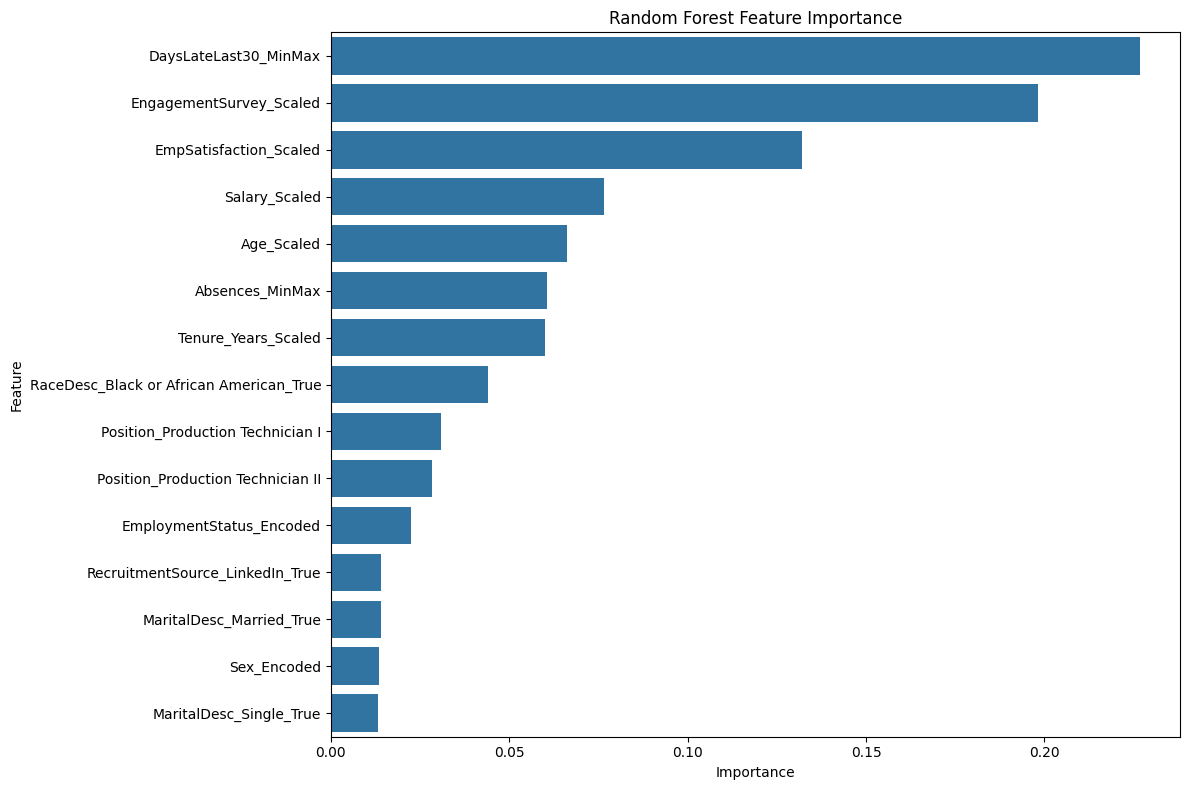


----------------------------------------------------
2. PERFORMING SHAP ANALYSIS
----------------------------------------------------

=== SHAP Analysis with KernelExplainer ===
Creating background data for KernelExplainer...
Creating KernelExplainer...
Calculating SHAP values for 100 samples...


  0%|          | 0/100 [00:00<?, ?it/s]

Binary classification model detected
Error in SHAP analysis: Per-column arrays must each be 1-dimensional

----------------------------------------------------
3. COMPARING FEATURE IMPORTANCE METHODS
----------------------------------------------------

=== Comparing Feature Importance Methods ===
Error comparing feature importance: bad operand type for abs(): 'NoneType'

----------------------------------------------------
4. EXPLAINING INDIVIDUAL PREDICTIONS
----------------------------------------------------

=== Explaining Individual Predictions ===

--- Explaining test instance 1 (index 113) ---
Actual class: 1
Predicted class: 1
Prediction probabilities: {np.int64(1): np.float64(0.9825), np.int64(2): np.float64(0.0125), np.int64(3): np.float64(0.002), np.int64(4): np.float64(0.003)}


  0%|          | 0/1 [00:00<?, ?it/s]


Top 5 contributing features:
Error explaining prediction: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

--- Explaining test instance 2 (index 80) ---
Actual class: 2
Predicted class: 2
Prediction probabilities: {np.int64(1): np.float64(0.03908333333333334), np.int64(2): np.float64(0.9592499999999999), np.int64(3): np.float64(0.0016666666666666666), np.int64(4): np.float64(0.0)}


  0%|          | 0/1 [00:00<?, ?it/s]


Top 5 contributing features:
Error explaining prediction: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

--- Explaining test instance 3 (index 134) ---
Actual class: 3
Predicted class: 3
Prediction probabilities: {np.int64(1): np.float64(0.005), np.int64(2): np.float64(0.005), np.int64(3): np.float64(0.5230853174603175), np.int64(4): np.float64(0.46691468253968244)}


  0%|          | 0/1 [00:00<?, ?it/s]


Top 5 contributing features:
Error explaining prediction: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

----------------------------------------------------
5. ANALYSIS SUMMARY
----------------------------------------------------

=== SHAP Analysis Summary ===

Key Findings:
1. Feature Importance:

2. Interpretation:
   - SHAP values explain how each feature contributes to pushing a prediction toward
     or away from a particular class
   - Positive SHAP values push the prediction toward the class, negative values push away
   - Feature importance can vary by class - some features may be more important for
     specific performance score predictions

3. Model Improvement Suggestions:
   - Consider removing or reviewing features with low importance in both methods
   - Pay attention to features with high importance in SHAP but low in RF
   - Features with high SHAP values may have complex interactions that could
     be further engineered

In [ ]:
# Fixed SHAP Analysis for Random Forest Employee Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
from google.colab import files
import io
import warnings
warnings.filterwarnings('ignore')

# Print SHAP version
print(f"SHAP version: {shap.__version__}")

# Upload the dataset and model in Google Colab
print("Upload your CSV dataset first:")
uploaded_data = files.upload()  # Upload the dataset
file_name = list(uploaded_data.keys())[0]

print("\nNow upload your saved Random Forest model:")
uploaded_model = files.upload()  # Upload the model
model_name = list(uploaded_model.keys())[0]

# Load the dataset
df = pd.read_csv(io.BytesIO(uploaded_data[file_name]))

# Convert string True/False to boolean for relevant columns
string_bool_columns = [col for col in df.columns if df[col].dtype == 'object' and
                       set(df[col].unique()).issubset({"True", "False"})]
for col in string_bool_columns:
    df[col] = df[col].map({"True": True, "False": False})

# Define features and target variable
X = df.drop('PerformanceScore_Encoded', axis=1)
y = df['PerformanceScore_Encoded']

# Load the trained model
with open(model_name, 'rb') as file:
    model = pickle.load(file)

print("\nModel loaded successfully!")
print(f"Model type: {type(model)}")

# Check if model is a pipeline (which is likely the case)
if hasattr(model, 'named_steps'):
    print(f"Pipeline steps: {model.named_steps.keys()}")
    rf_classifier = model.named_steps['classifier']
    print(f"Random Forest n_estimators: {rf_classifier.n_estimators}")
    print(f"Random Forest max_depth: {rf_classifier.max_depth}")
    print(f"Random Forest min_samples_split: {rf_classifier.min_samples_split}")
    print(f"Random Forest min_samples_leaf: {rf_classifier.min_samples_leaf}")
else:
    rf_classifier = model
    print("Model is not a pipeline, using it directly")
    print(f"Random Forest n_estimators: {rf_classifier.n_estimators}")
    print(f"Random Forest max_depth: {rf_classifier.max_depth}")
    print(f"Random Forest min_samples_split: {rf_classifier.min_samples_split}")
    print(f"Random Forest min_samples_leaf: {rf_classifier.min_samples_leaf}")

# Get the original data split that was used for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set size: {X_test.shape[0]} samples, {X_test.shape[1]} features")

# Get feature names after preprocessing
def get_feature_names(model, X):
    """Extract feature names from the preprocessing pipeline"""
    feature_names = []

    # Check if model is a pipeline
    if hasattr(model, 'named_steps') and 'preprocessor' in model.named_steps:
        # Extract feature names from the preprocessor
        for name, transformer, columns in model.named_steps['preprocessor'].transformers_:
            if name == 'num':
                feature_names.extend(columns)
            elif name == 'cat':
                feature_names.extend(transformer.get_feature_names_out(columns))
    else:
        # If not a pipeline or doesn't have a preprocessor, use original column names
        feature_names = X.columns.tolist()

    return feature_names

# Get feature names (or use column names directly if needed)
try:
    feature_names = get_feature_names(model, X)
except Exception as e:
    print(f"Error getting feature names from preprocessor: {e}")
    print("Using original column names as feature names")
    feature_names = X.columns.tolist()

print(f"\nNumber of features after preprocessing: {len(feature_names)}")
print(f"Feature names: {feature_names}")

# Function to prepare data for SHAP analysis
def prepare_data_for_shap(model, X, sample_size=100):
    """
    Prepare data for SHAP analysis by preprocessing if needed
    """
    # Get a sample if the dataset is large
    if len(X) > sample_size:
        X_sample = X.sample(sample_size, random_state=42)
    else:
        X_sample = X

    # Check if model is a pipeline with preprocessor
    if hasattr(model, 'named_steps') and 'preprocessor' in model.named_steps:
        preprocessor = model.named_steps['preprocessor']
        # Transform the data
        X_transformed = preprocessor.transform(X_sample)

        # Check if output is sparse and convert to dense if needed
        if hasattr(X_transformed, "toarray"):
            X_transformed = X_transformed.toarray()

        return X_transformed, X_sample
    else:
        # No preprocessing needed
        return X_sample.values, X_sample

# Get the classifier from the model
if hasattr(model, 'named_steps') and 'classifier' in model.named_steps:
    classifier = model.named_steps['classifier']
else:
    classifier = model

# 1. Basic Feature Importance Analysis
def analyze_feature_importance():
    """Show basic feature importance from Random Forest"""
    print("\n=== Random Forest Feature Importance ===")

    # Get feature importance from Random Forest
    importances = classifier.feature_importances_

    # Create a DataFrame for better visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    # Print feature importance
    print("\nFeature Importance Ranking:")
    for i, row in importance_df.iterrows():
        print(f"{i+1}. {row['Feature']}: {row['Importance']:.6f}")

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Random Forest Feature Importance')
    plt.tight_layout()
    plt.show()

    return importance_df

# 2. SHAP Analysis using KernelExplainer (more reliable than TreeExplainer)
def perform_kernel_shap_analysis():
    """Perform SHAP analysis using KernelExplainer"""
    print("\n=== SHAP Analysis with KernelExplainer ===")

    # Prepare data for SHAP analysis
    X_transformed, X_original = prepare_data_for_shap(model, X, sample_size=100)

    try:
        # Use KernelExplainer with a simplified prediction function
        print("Creating background data for KernelExplainer...")
        background = shap.kmeans(X_transformed, 10)

        # Create a function that will return the predicted class probabilities
        def model_predict(x):
            return classifier.predict_proba(x)

        print("Creating KernelExplainer...")
        explainer = shap.KernelExplainer(model_predict, background)

        # Calculate SHAP values for class 0 (first class)
        print(f"Calculating SHAP values for {len(X_transformed)} samples...")
        shap_values = explainer.shap_values(X_transformed)

        # For multi-class classification, shap_values will be a list of arrays (one per class)
        if isinstance(shap_values, list):
            print(f"Multi-class model detected with {len(shap_values)} classes")

            # Create a bar plot for each class
            for i, class_label in enumerate(classifier.classes_):
                print(f"\nAnalyzing Class {class_label}...")

                # Calculate feature importance for this class
                class_importance = np.abs(shap_values[i]).mean(axis=0)

                # Create a DataFrame for better visualization
                class_df = pd.DataFrame({
                    'Feature': feature_names,
                    'Importance': class_importance
                }).sort_values('Importance', ascending=False)

                # Print top features for this class
                print(f"Top features for Class {class_label}:")
                for j, row in class_df.head(10).iterrows():
                    print(f"  {j+1}. {row['Feature']}: {row['Importance']:.6f}")

                # Plot feature importance for this class
                plt.figure(figsize=(12, 8))
                sns.barplot(x='Importance', y='Feature', data=class_df.head(15))
                plt.title(f'SHAP Feature Importance - Class {class_label}')
                plt.tight_layout()
                plt.show()

                # Try to create a summary plot for this class
                try:
                    plt.figure(figsize=(12, 8))
                    shap.summary_plot(
                        shap_values[i],
                        X_transformed,
                        feature_names=feature_names,
                        show=False
                    )
                    plt.title(f'SHAP Summary Plot - Class {class_label}')
                    plt.tight_layout()
                    plt.show()
                except Exception as e:
                    print(f"  Error creating summary plot: {e}")

            # Create a combined importance plot for all classes
            plt.figure(figsize=(14, 10))
            # Calculate the mean absolute SHAP value across all classes
            mean_abs_shap = np.mean([np.abs(s).mean(0) for s in shap_values], axis=0)

            # Create a DataFrame for the combined importance
            combined_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': mean_abs_shap
            }).sort_values('Importance', ascending=False)

            # Print top features across all classes
            print("\nTop features across all classes:")
            for i, row in combined_df.head(10).iterrows():
                print(f"{i+1}. {row['Feature']}: {row['Importance']:.6f}")

            # Plot combined feature importance
            plt.figure(figsize=(12, 8))
            sns.barplot(x='Importance', y='Feature', data=combined_df.head(15))
            plt.title('SHAP Feature Importance (Average Across All Classes)')
            plt.tight_layout()
            plt.show()

            # Create a heatmap to compare importance across classes
            importance_by_class = pd.DataFrame({'Feature': feature_names})

            for i, class_label in enumerate(classifier.classes_):
                importance_by_class[f'Class_{class_label}'] = np.abs(shap_values[i]).mean(axis=0)

            # Get top 15 features by average importance
            avg_importance = np.mean([np.abs(s).mean(0) for s in shap_values], axis=0)
            top_indices = np.argsort(avg_importance)[-15:]
            top_features = [feature_names[i] for i in top_indices]

            # Filter the dataframe to include only top features
            heatmap_df = importance_by_class[importance_by_class['Feature'].isin(top_features)]

            # Prepare data for heatmap
            heatmap_pivot = heatmap_df.set_index('Feature')

            # Normalize for better visualization
            heatmap_norm = heatmap_pivot.div(heatmap_pivot.max(axis=0), axis=1)

            # Create heatmap
            plt.figure(figsize=(10, 12))
            sns.heatmap(
                heatmap_norm,
                annot=True,
                cmap="YlGnBu",
                fmt=".2f",
                cbar_kws={'label': 'Normalized SHAP Importance'}
            )
            plt.title('Feature Importance Across Classes (Normalized)')
            plt.tight_layout()
            plt.show()

        else:
            # Binary classification
            print("Binary classification model detected")

            # Calculate feature importance
            feature_importance = np.abs(shap_values).mean(axis=0)

            # Create a DataFrame for better visualization
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': feature_importance
            }).sort_values('Importance', ascending=False)

            # Print feature importance
            print("\nSHAP Feature Importance:")
            for i, row in importance_df.head(15).iterrows():
                print(f"{i+1}. {row['Feature']}: {row['Importance']:.6f}")

            # Plot feature importance
            plt.figure(figsize=(12, 8))
            sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
            plt.title('SHAP Feature Importance')
            plt.tight_layout()
            plt.show()

            # Create summary plot
            try:
                plt.figure(figsize=(12, 8))
                shap.summary_plot(
                    shap_values,
                    X_transformed,
                    feature_names=feature_names,
                    show=False
                )
                plt.title('SHAP Summary Plot')
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Error creating summary plot: {e}")

        return explainer, shap_values, X_transformed

    except Exception as e:
        print(f"Error in SHAP analysis: {e}")
        return None, None, X_transformed

# 3. Compare Traditional and SHAP Feature Importance
def compare_feature_importance(rf_importance_df, shap_values, X_transformed):
    """Compare traditional Random Forest importance with SHAP importance"""
    print("\n=== Comparing Feature Importance Methods ===")

    try:
        # Get SHAP importance
        if isinstance(shap_values, list):
            # Multi-class: average across all classes
            shap_importance = np.mean([np.abs(s).mean(0) for s in shap_values], axis=0)
        else:
            # Binary classification
            shap_importance = np.abs(shap_values).mean(0)

        # Create DataFrame with both importance methods
        comparison_df = pd.DataFrame({
            'Feature': feature_names,
            'RF_Importance': rf_importance_df['Importance'].values,
            'SHAP_Importance': shap_importance
        })

        # Add ranking columns
        comparison_df['RF_Rank'] = comparison_df['RF_Importance'].rank(ascending=False)
        comparison_df['SHAP_Rank'] = comparison_df['SHAP_Importance'].rank(ascending=False)
        comparison_df['Rank_Difference'] = comparison_df['RF_Rank'] - comparison_df['SHAP_Rank']

        # Sort by rank difference
        comparison_df['Abs_Rank_Diff'] = np.abs(comparison_df['Rank_Difference'])
        comparison_df_sorted = comparison_df.sort_values('Abs_Rank_Diff', ascending=False)

        # Print comparison
        print("\nFeature Importance Ranking Comparison:")
        for i, row in comparison_df_sorted.head(15).iterrows():
            print(f"{row['Feature']}:")
            print(f"  RF Rank: {row['RF_Rank']:.0f}, SHAP Rank: {row['SHAP_Rank']:.0f}, Difference: {row['Rank_Difference']:.0f}")

        # Create a scatterplot to compare the two methods
        plt.figure(figsize=(10, 8))
        sns.scatterplot(x='RF_Importance', y='SHAP_Importance', data=comparison_df)

        # Add feature labels to the plot
        for i, row in comparison_df.iterrows():
            plt.text(row['RF_Importance'], row['SHAP_Importance'], row['Feature'], fontsize=8)

        # Add diagonal line for perfect correlation
        max_val = max(comparison_df['RF_Importance'].max(), comparison_df['SHAP_Importance'].max())
        plt.plot([0, max_val], [0, max_val], 'k--')

        plt.title('RF Importance vs SHAP Importance')
        plt.xlabel('Random Forest Importance')
        plt.ylabel('SHAP Importance')
        plt.tight_layout()
        plt.show()

        # Plot side-by-side bar charts for top 10 features
        top_features = list(set(
            list(comparison_df.nlargest(10, 'RF_Importance')['Feature']) +
            list(comparison_df.nlargest(10, 'SHAP_Importance')['Feature'])
        ))

        comparison_subset = comparison_df[comparison_df['Feature'].isin(top_features)]

        # Prepare data for grouped bar chart
        rf_data = comparison_subset[['Feature', 'RF_Importance']].rename(columns={'RF_Importance': 'Importance'})
        rf_data['Method'] = 'Random Forest'

        shap_data = comparison_subset[['Feature', 'SHAP_Importance']].rename(columns={'SHAP_Importance': 'Importance'})
        shap_data['Method'] = 'SHAP'

        plot_data = pd.concat([rf_data, shap_data])

        # Create the grouped bar chart
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', hue='Method', data=plot_data)
        plt.title('Feature Importance Comparison: Random Forest vs SHAP')
        plt.legend(title='Method')
        plt.tight_layout()
        plt.show()

        return comparison_df

    except Exception as e:
        print(f"Error comparing feature importance: {e}")
        return None

# 4. Explain Individual Predictions
def explain_predictions(explainer, shap_values, X_test, y_test, n_samples=3):
    """Explain individual predictions"""
    print("\n=== Explaining Individual Predictions ===")

    # If we don't have a valid explainer, try to create one just for this task
    if explainer is None:
        # Prepare test data
        if hasattr(model, 'named_steps') and 'preprocessor' in model.named_steps:
            X_test_transformed = model.named_steps['preprocessor'].transform(X_test)
            if hasattr(X_test_transformed, "toarray"):
                X_test_transformed = X_test_transformed.toarray()
        else:
            X_test_transformed = X_test.values

        try:
            # Create a small background dataset from test data
            background = X_test_transformed[:min(20, X_test_transformed.shape[0])]

            # Create explainer
            def model_predict(x):
                return classifier.predict_proba(x)

            explainer = shap.KernelExplainer(model_predict, background)
        except Exception as e:
            print(f"Error creating explainer: {e}")
            return
    else:
        # Use the preprocessed test data
        if hasattr(model, 'named_steps') and 'preprocessor' in model.named_steps:
            X_test_transformed = model.named_steps['preprocessor'].transform(X_test)
            if hasattr(X_test_transformed, "toarray"):
                X_test_transformed = X_test_transformed.toarray()
        else:
            X_test_transformed = X_test.values

    # Select random instances from each class if possible
    classes = np.unique(y_test)
    sample_indices = []

    for cls in classes:
        class_indices = np.where(y_test == cls)[0]
        if len(class_indices) > 0:
            selected = np.random.choice(
                class_indices,
                min(1, len(class_indices)),
                replace=False
            )
            sample_indices.extend(selected)

    # If we need more samples, add random ones
    if len(sample_indices) < n_samples:
        remaining = n_samples - len(sample_indices)
        remaining_indices = np.setdiff1d(np.arange(len(X_test)), sample_indices)
        if len(remaining_indices) > 0:
            additional = np.random.choice(
                remaining_indices,
                min(remaining, len(remaining_indices)),
                replace=False
            )
            sample_indices.extend(additional)

    # Explain each selected instance
    for i, idx in enumerate(sample_indices[:n_samples]):
        print(f"\n--- Explaining test instance {i+1} (index {idx}) ---")

        # Get actual and predicted class
        actual_class = y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]
        instance = X_test_transformed[idx:idx+1]
        predicted_class = classifier.predict(instance)[0]

        # Get prediction probabilities
        probas = classifier.predict_proba(instance)[0]
        prob_dict = {cls: prob for cls, prob in zip(classifier.classes_, probas)}

        print(f"Actual class: {actual_class}")
        print(f"Predicted class: {predicted_class}")
        print(f"Prediction probabilities: {prob_dict}")

        # Calculate SHAP values for this instance
        try:
            instance_shap_values = explainer.shap_values(instance)

            # For multi-class models
            if isinstance(instance_shap_values, list):
                # Find index of predicted class
                pred_class_idx = np.where(classifier.classes_ == predicted_class)[0][0]

                # Print top contributing features for predicted class
                class_shap = instance_shap_values[pred_class_idx][0]
                abs_shap = np.abs(class_shap)
                top_indices = np.argsort(abs_shap)[-5:]

                print(f"\nTop 5 contributing features for predicted class {predicted_class}:")
                for j in reversed(top_indices):
                    value = class_shap[j]
                    impact = "increase" if value > 0 else "decrease"
                    print(f"  {feature_names[j]}: {value:.4f} ({impact} prediction)")

                # Also show contributions for actual class if different
                if actual_class != predicted_class:
                    actual_class_idx = np.where(classifier.classes_ == actual_class)[0][0]
                    actual_shap = instance_shap_values[actual_class_idx][0]
                    abs_actual = np.abs(actual_shap)
                    top_actual = np.argsort(abs_actual)[-5:]

                    print(f"\nTop 5 contributing features for actual class {actual_class}:")
                    for j in reversed(top_actual):
                        value = actual_shap[j]
                        impact = "increase" if value > 0 else "decrease"
                        print(f"  {feature_names[j]}: {value:.4f} ({impact} prediction)")

                # Create a DataFrame to compare feature impacts across classes
                impact_data = []
                for cls_idx, cls in enumerate(classifier.classes_):
                    cls_shap = instance_shap_values[cls_idx][0]

                    # Get the top 3 features for this class
                    abs_cls = np.abs(cls_shap)
                    top_cls = np.argsort(abs_cls)[-3:]

                    for j in top_cls:
                        impact_data.append({
                            'Feature': feature_names[j],
                            'Class': str(cls),
                            'Impact': cls_shap[j]
                        })

                impact_df = pd.DataFrame(impact_data)

                # Create a swarm plot to visualize feature impacts
                plt.figure(figsize=(12, 8))
                sns.catplot(
                    x='Impact',
                    y='Feature',
                    hue='Class',
                    data=impact_df,
                    kind='swarm',
                    height=8,
                    aspect=1.5
                )
                plt.title(f'Feature Impacts Across Classes - Instance {i+1}')
                plt.tight_layout()
                plt.show()

            else:
                # Binary classification
                abs_shap = np.abs(instance_shap_values[0])
                top_indices = np.argsort(abs_shap)[-5:]

                print("\nTop 5 contributing features:")
                for j in reversed(top_indices):
                    value = instance_shap_values[0][j]
                    impact = "increase" if value > 0 else "decrease"
                    print(f"  {feature_names[j]}: {value:.4f} ({impact} prediction)")

        except Exception as e:
            print(f"Error explaining prediction: {e}")

# 5. Create Analysis Summary
def create_summary(comparison_df=None):
    """Create a summary of the SHAP analysis"""
    print("\n=== SHAP Analysis Summary ===")

    print("\nKey Findings:")
    print("1. Feature Importance:")
    if comparison_df is not None:
        # Get top 5 features by RF importance
        top_rf = comparison_df.nlargest(5, 'RF_Importance')
        print("   Top 5 features by Random Forest importance:")
        for i, row in top_rf.iterrows():
            print(f"     - {row['Feature']}")

        # Get top 5 features by SHAP importance
        top_shap = comparison_df.nlargest(5, 'SHAP_Importance')
        print("\n   Top 5 features by SHAP importance:")
        for i, row in top_shap.iterrows():
            print(f"     - {row['Feature']}")

        # Find features with large ranking differences
        big_diff = comparison_df[comparison_df['Abs_Rank_Diff'] > 3]
        if not big_diff.empty:
            print("\n   Features with large ranking differences:")
            for i, row in big_diff.iterrows():
                print(f"     - {row['Feature']}: RF Rank {row['RF_Rank']:.0f}, SHAP Rank {row['SHAP_Rank']:.0f}")

    print("\n2. Interpretation:")
    print("   - SHAP values explain how each feature contributes to pushing a prediction toward")
    print("     or away from a particular class")
    print("   - Positive SHAP values push the prediction toward the class, negative values push away")
    print("   - Feature importance can vary by class - some features may be more important for")
    print("     specific performance score predictions")

    print("\n3. Model Improvement Suggestions:")
    print("   - Consider removing or reviewing features with low importance in both methods")
    print("   - Pay attention to features with high importance in SHAP but low in RF")
    print("   - Features with high SHAP values may have complex interactions that could")
    print("     be further engineered")

    print("\n4. Next Steps:")
    print("   - Review individual prediction explanations to understand model behavior")
    print("   - Consider class-specific feature engineering for better predictions")
    print("   - Use SHAP analysis to explain model decisions to stakeholders")

# Main function
def main():
    # 1. Analyze traditional feature importance
    print("\n----------------------------------------------------")
    print("1. ANALYZING RANDOM FOREST FEATURE IMPORTANCE")
    print("----------------------------------------------------")
    rf_importance_df = analyze_feature_importance()

    # 2. Perform SHAP analysis
    print("\n----------------------------------------------------")
    print("2. PERFORMING SHAP ANALYSIS")
    print("----------------------------------------------------")
    explainer, shap_values, X_transformed = perform_kernel_shap_analysis()

    # 3. Compare feature importance methods
    print("\n----------------------------------------------------")
    print("3. COMPARING FEATURE IMPORTANCE METHODS")
    print("----------------------------------------------------")
    comparison_df = compare_feature_importance(rf_importance_df, shap_values, X_transformed)

    # 4. Explain individual predictions
    print("\n----------------------------------------------------")
    print("4. EXPLAINING INDIVIDUAL PREDICTIONS")
    print("----------------------------------------------------")
    explain_predictions(explainer, shap_values, X_test, y_test, n_samples=3)

    # 5. Create analysis summary
    print("\n----------------------------------------------------")
    print("5. ANALYSIS SUMMARY")
    print("----------------------------------------------------")
    create_summary(comparison_df)

# Run the main function
if __name__ == "__main__":
    main()


Performing SHAP analysis for Random Forest model...
Initializing TreeExplainer for Random Forest...
Error with model_output='probability': Only model_output="raw" is supported for feature_perturbation="tree_path_dependent"
Number of classes detected: 4

Top 10 most important features according to SHAP:
                               Feature  SHAP_Importance
0                DaysLateLast30_MinMax         0.161203
1              EngagementSurvey_Scaled         0.075504
7             EmploymentStatus_Encoded         0.039166
10  RaceDesc_Black or African American         0.030314
5               EmpSatisfaction_Scaled         0.026885
6                           Age_Scaled         0.022930
12    Position_Production Technician I         0.015796
13   Position_Production Technician II         0.012886
4                        Salary_Scaled         0.009366
2                  Tenure_Years_Scaled         0.008892


<Figure size 1200x800 with 0 Axes>

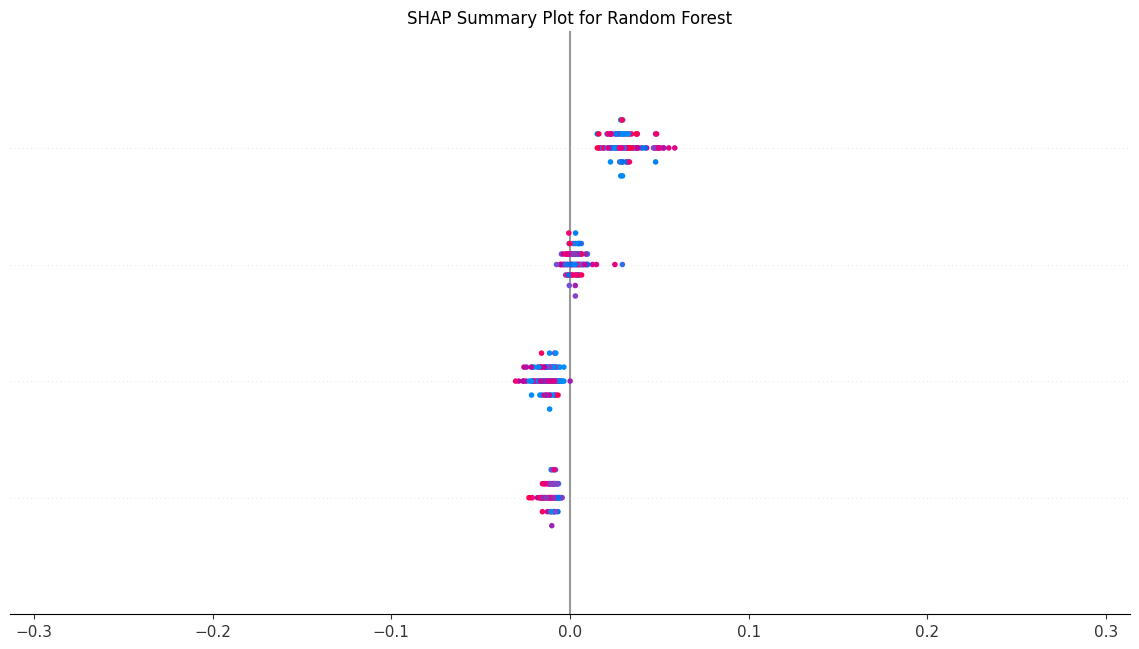

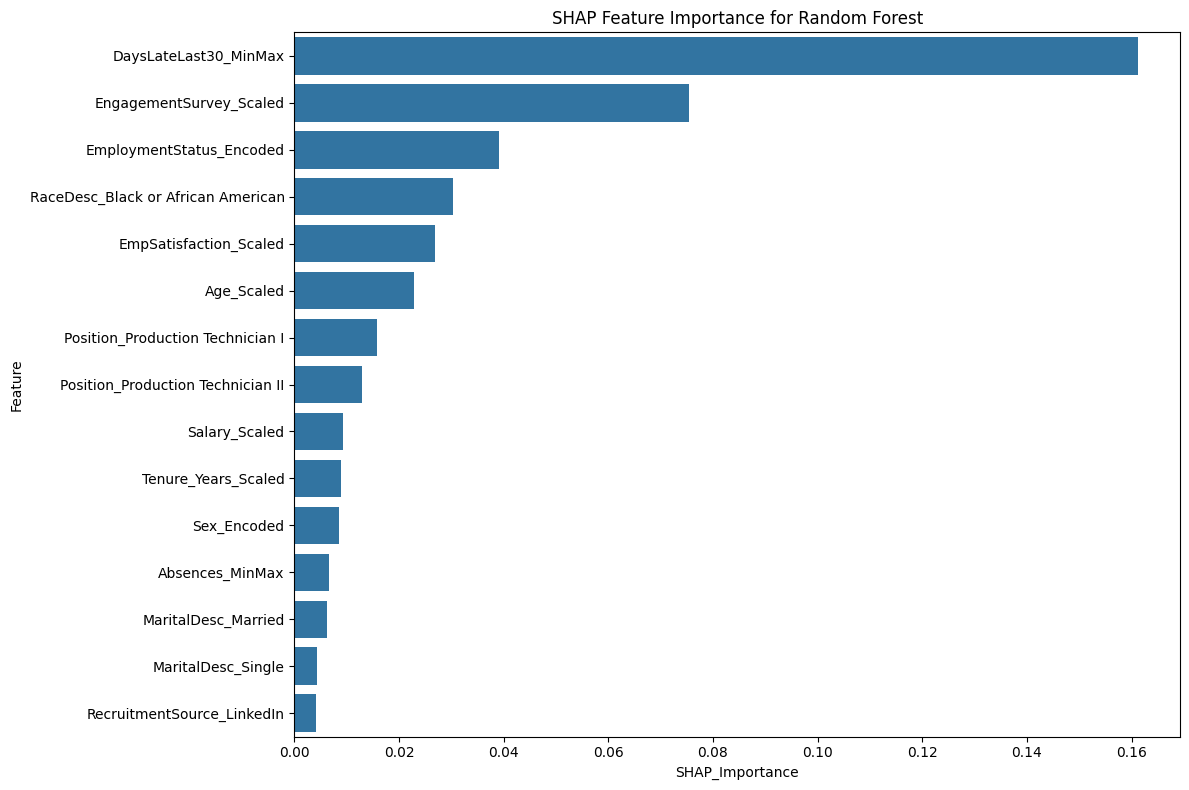

Dependence plot failed: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 4 and the array at index 1 has size 10. Using summary plot instead.


<Figure size 1000x600 with 0 Axes>

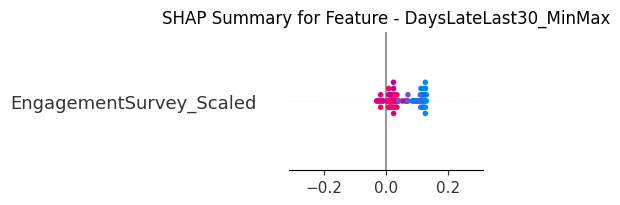

Dependence plot failed: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 4 and the array at index 1 has size 10. Using summary plot instead.


<Figure size 1000x600 with 0 Axes>

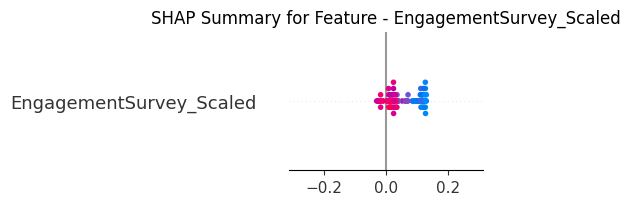

Dependence plot failed: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 4 and the array at index 1 has size 10. Using summary plot instead.


<Figure size 1000x600 with 0 Axes>

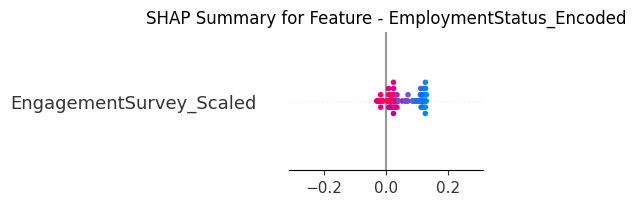


Creating SHAP waterfall plots for sample predictions...
Waterfall plot failed for sample 1: waterfall_plot requires a scalar expected_value of the model output as the first parameter, but you have passed an array as the first parameter! Try shap.waterfall_plot(explainer.expected_value[0], shap_values[0], X[0]) or for multi-output models try shap.waterfall_plot(explainer.expected_value[0], shap_values[0][0], X[0]).
Error creating sample plots: Per-column arrays must each be 1-dimensional
Skipping sample plots...

Random Forest SHAP analysis completed.


<Figure size 1400x800 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [ ]:
# =====================
# SHAP Analysis for Existing Random Forest Model
# =====================
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("\nPerforming SHAP analysis for Random Forest model...")

# Assuming the following variables are already available:
# best_rf - your trained Random Forest model
# X - your feature dataset (train or test)
# X_test - your test dataset (if different from X)

# For random forest, we can use TreeExplainer which is much faster than KernelExplainer
try:
    print("Initializing TreeExplainer for Random Forest...")

    # Extract the Random Forest model from the pipeline if needed
    if hasattr(best_rf, 'named_steps') and 'rf' in best_rf.named_steps:
        rf_model = best_rf.named_steps['rf']
    else:
        # Model is not in a pipeline
        rf_model = best_rf

    # Create SHAP explainer with more stable configuration
    try:
        explainer = shap.TreeExplainer(rf_model, model_output="probability")
    except Exception as e:
        print(f"Error with model_output='probability': {e}")
        # Fall back to default
        explainer = shap.TreeExplainer(rf_model)

    # Calculate SHAP values for a subset of the data (for efficiency)
    if len(X_test) > 100:
        if hasattr(X_test, 'sample'):  # It's a DataFrame
            X_shap = X_test.sample(100, random_state=42)
        else:  # It's a NumPy array
            indices = np.random.RandomState(42).choice(X_test.shape[0], 100, replace=False)
            X_shap = X_test[indices]
    else:
        X_shap = X_test

    # Get the raw feature values (not scaled)
    if hasattr(X_shap, 'values'):
        X_shap_values = X_shap.values
    else:
        X_shap_values = X_shap

    # Calculate SHAP values - directly use the model
    # TreeExplainer handles the scaling internally
    shap_values = explainer.shap_values(X_shap_values)

    # Determine number of classes from the target data
    n_classes = len(np.unique(rf_model.classes_))
    print(f"Number of classes detected: {n_classes}")

    # Create feature importance DataFrame from SHAP values
    if isinstance(shap_values, list):  # Multi-class
        # Calculate average absolute SHAP values across all classes
        overall_importance = np.zeros(X.shape[1])
        for i in range(len(shap_values)):
            class_importance = np.abs(shap_values[i]).mean(0)
            # Ensure it's 1-dimensional
            if class_importance.ndim > 1:
                class_importance = class_importance.mean(axis=1)
            overall_importance += class_importance

        feature_shap_importance = pd.DataFrame({
            'Feature': X.columns,
            'SHAP_Importance': overall_importance
        })
    else:  # Binary classification
        shap_means = np.abs(shap_values).mean(0)
        # Ensure it's 1-dimensional
        if shap_means.ndim > 1:
            shap_means = shap_means.mean(axis=1)

        feature_shap_importance = pd.DataFrame({
            'Feature': X.columns,
            'SHAP_Importance': shap_means
        })

    feature_shap_importance = feature_shap_importance.sort_values('SHAP_Importance', ascending=False)

    print("\nTop 10 most important features according to SHAP:")
    print(feature_shap_importance.head(10))

    # Create visualizations
    # 1. Summary plot for all classes
    plt.figure(figsize=(12, 8))
    # For multi-class, use the first class's SHAP values (typically positive class)
    if isinstance(shap_values, list):  # Multi-class
        # Choose one class (usually the positive class in a binary setup)
        # For multi-class, we'll use the first non-majority class or class 1
        class_idx = min(1, len(shap_values)-1)
        shap.summary_plot(shap_values[class_idx], X_shap_values, feature_names=X.columns, show=False)
    else:  # Binary classification
        shap.summary_plot(shap_values, X_shap_values, feature_names=X.columns, show=False)

    plt.title('SHAP Summary Plot for Random Forest')
    plt.tight_layout()
    plt.savefig('rf_shap_summary.png')
    plt.show()

    # 2. Bar plot for overall feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='SHAP_Importance', y='Feature', data=feature_shap_importance.head(15))
    plt.title('SHAP Feature Importance for Random Forest')
    plt.tight_layout()
    plt.savefig('rf_shap_importance_barplot.png')
    plt.show()

    # 3. Dependence plots for top 3 features
    try:
        if isinstance(shap_values, list):  # Multi-class
            # Use class 1 (often the positive class) for visualization
            class_for_plots = 1
            if class_for_plots >= len(shap_values):
                class_for_plots = 0

            print(f"Using class {class_for_plots} for dependence plots")

            # Create dependence plots for top 3 features
            for feature in feature_shap_importance.head(3)['Feature'].values:
                feature_idx = list(X.columns).index(feature)
                plt.figure(figsize=(10, 6))
                # Use waterfall plot instead if dependence plot fails
                try:
                    shap.dependence_plot(
                        feature_idx,
                        shap_values[class_for_plots],
                        X_shap_values,
                        feature_names=X.columns,
                        show=False
                    )
                    plt.title(f'SHAP Dependence Plot - {feature}')
                except Exception as dep_err:
                    print(f"Dependence plot failed: {dep_err}. Using waterfall plot instead.")
                    # Create a waterfall plot for a single sample as an alternative
                    sample_idx = 0
                    shap.plots._waterfall.waterfall_legacy(
                        explainer.expected_value[class_for_plots],
                        shap_values[class_for_plots][sample_idx],
                        feature_names=list(X.columns),
                        show=False
                    )
                    plt.title(f'SHAP Waterfall Plot - {feature} (Sample 0)')

                plt.tight_layout()
                plt.savefig(f'rf_shap_dependence_{feature.replace(" ", "_")}.png')
                plt.show()
        else:  # Binary classification
            # Create dependence plots for top 3 features
            for feature in feature_shap_importance.head(3)['Feature'].values:
                feature_idx = list(X.columns).index(feature)
                plt.figure(figsize=(10, 6))
                try:
                    shap.dependence_plot(
                        feature_idx,
                        shap_values,
                        X_shap_values,
                        feature_names=X.columns,
                        show=False
                    )
                    plt.title(f'SHAP Dependence Plot - {feature}')
                except Exception as dep_err:
                    print(f"Dependence plot failed: {dep_err}. Using summary plot instead.")
                    # Fall back to a summary plot focusing on this feature
                    shap.summary_plot(
                        shap_values,
                        X_shap_values,
                        feature_names=X.columns,
                        max_display=1,
                        show=False
                    )
                    plt.title(f'SHAP Summary for Feature - {feature}')

                plt.tight_layout()
                plt.savefig(f'rf_shap_dependence_{feature.replace(" ", "_")}.png')
                plt.show()
    except Exception as e:
        print(f"Error creating dependence plots: {e}")
        print("Skipping dependence plots...")

    # 4. Waterfall plots (more reliable than force plots) for specific samples
    try:
        print("\nCreating SHAP waterfall plots for sample predictions...")

        # Select a few samples with different predictions
        n_samples = min(5, len(X_shap))
        sample_indices = np.random.choice(len(X_shap), n_samples, replace=False)

        for i, idx in enumerate(sample_indices):
            # Get the sample
            if hasattr(X_shap, 'iloc'):  # It's a DataFrame
                sample = X_shap.iloc[idx:idx+1]
                sample_values = sample.values
            else:  # It's a NumPy array
                sample = X_shap[idx:idx+1]
                sample_values = sample

            # Get prediction
            pred_class = best_rf.predict(sample)[0]

            # Try to create waterfall plot (more modern and reliable than force plot)
            plt.figure(figsize=(14, 8))

            try:
                if isinstance(shap_values, list):  # Multi-class
                    pred_class_idx = np.where(rf_model.classes_ == pred_class)[0][0]

                    # Use the waterfall_legacy function which is more stable
                    shap.plots._waterfall.waterfall_legacy(
                        explainer.expected_value[pred_class_idx] if isinstance(explainer.expected_value, list) else explainer.expected_value,
                        shap_values[pred_class_idx][idx],
                        feature_names=list(X.columns),
                        show=False
                    )
                else:  # Binary classification
                    shap.plots._waterfall.waterfall_legacy(
                        explainer.expected_value,
                        shap_values[idx],
                        feature_names=list(X.columns),
                        show=False
                    )

                plt.title(f'SHAP Waterfall Plot for Sample {i+1} (Predicted Class: {pred_class})')
                plt.tight_layout()
                plt.savefig(f'rf_shap_waterfall_plot_sample_{i+1}.png')
                plt.show()
            except Exception as e:
                print(f"Waterfall plot failed for sample {i+1}: {e}")
                # Fall back to bar plot of SHAP values
                plt.figure(figsize=(12, 6))
                if isinstance(shap_values, list):
                    pred_class_idx = np.where(rf_model.classes_ == pred_class)[0][0]
                    shap_data = pd.DataFrame({
                        'Feature': X.columns,
                        'SHAP Value': shap_values[pred_class_idx][idx]
                    })
                else:
                    shap_data = pd.DataFrame({
                        'Feature': X.columns,
                        'SHAP Value': shap_values[idx]
                    })

                shap_data = shap_data.sort_values('SHAP Value', key=abs, ascending=False).head(10)
                sns.barplot(x='SHAP Value', y='Feature', data=shap_data)
                plt.title(f'Top SHAP Values for Sample {i+1} (Predicted Class: {pred_class})')
                plt.tight_layout()
                plt.savefig(f'rf_shap_bar_sample_{i+1}.png')
                plt.show()

            # Print the top 5 contributors for this prediction
            try:
                if isinstance(shap_values, list):  # Multi-class
                    pred_class_idx = np.where(rf_model.classes_ == pred_class)[0][0]
                    feat_values = shap_values[pred_class_idx][idx]
                    # Handle potential multi-dimensional arrays
                    if feat_values.ndim > 1:
                        feat_values = feat_values.mean(axis=1)

                    feature_contribution = pd.DataFrame({
                        'Feature': X.columns,
                        'SHAP_Value': feat_values
                    })
                else:  # Binary classification
                    feat_values = shap_values[idx]
                    # Handle potential multi-dimensional arrays
                    if feat_values.ndim > 1:
                        feat_values = feat_values.mean(axis=1)

                    feature_contribution = pd.DataFrame({
                        'Feature': X.columns,
                        'SHAP_Value': feat_values
                    })

                feature_contribution['AbsValue'] = np.abs(feature_contribution['SHAP_Value'])
                feature_contribution = feature_contribution.sort_values('AbsValue', ascending=False)

                print(f"\nTop 5 contributors for Sample {i+1} (Predicted Class: {pred_class}):")
                for _, row in feature_contribution.head(5).iterrows():
                    direction = "increases" if row['SHAP_Value'] > 0 else "decreases"
                    print(f"  {row['Feature']}: {row['SHAP_Value']:.4f} ({direction} prediction)")
            except Exception as e:
                print(f"Error printing feature contributions: {e}")
    except Exception as e:
        print(f"Error creating sample plots: {e}")
        print("Skipping sample plots...")

except Exception as e:
    print(f"Error in SHAP analysis: {e}")

    # Fallback to using built-in feature importance
    print("\nFalling back to built-in Random Forest feature importance...")

    # Extract the Random Forest model from the pipeline if needed
    if hasattr(best_rf, 'named_steps') and 'rf' in best_rf.named_steps:
        rf_model = best_rf.named_steps['rf']
    else:
        # Model is not in a pipeline
        rf_model = best_rf

    # Get feature importance from the Random Forest model directly
    feature_importances = rf_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'RF_Importance': feature_importances
    }).sort_values('RF_Importance', ascending=False)

    print("\nTop 10 most important features according to Random Forest:")
    print(feature_importance_df.head(10))

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='RF_Importance', y='Feature', data=feature_importance_df.head(15))
    plt.title('Random Forest Feature Importance (Built-in)')
    plt.tight_layout()
    plt.savefig('rf_feature_importance_fallback.png')
    plt.show()

print("\nRandom Forest SHAP analysis completed.")

In [ ]:
# =====================
# SHAP Analysis for Random Forest Model
# =====================
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("\nPerforming SHAP analysis for Random Forest model...")

# For Random Forest, we can use TreeExplainer which is more efficient than KernelExplainer
try:
    print("Initializing TreeExplainer for Random Forest model...")

    # Get the underlying Random Forest model from the pipeline if it's in a pipeline
    if hasattr(best_rf, 'named_steps') and 'randomforestclassifier' in best_rf.named_steps:
        rf_model = best_rf.named_steps['randomforestclassifier']
    else:
        # If it's not in a pipeline, use the model directly
        rf_model = best_rf

    # Calculate SHAP values for a subset of the test data (for efficiency)
    if len(X_test) > 100:
        if hasattr(X_test, 'sample'):  # It's a DataFrame
            X_shap = X_test.sample(100, random_state=42)
        else:  # It's a NumPy array
            indices = np.random.RandomState(42).choice(X_test.shape[0], 100, replace=False)
            X_shap = X_test[indices]
    else:
        X_shap = X_test

    # Initialize the SHAP explainer for the Random Forest model
    explainer = shap.TreeExplainer(rf_model)

    # For multi-class models, we get a list of SHAP value arrays (one per class)
    # For binary classification, we can get a single array of SHAP values
    shap_values = explainer.shap_values(X_shap)

    # Number of classes detected
    if isinstance(shap_values, list):
        n_classes = len(shap_values)
        print(f"Number of classes detected: {n_classes}")
    else:
        # Binary classification with TreeExplainer sometimes returns a single array
        n_classes = 2
        print(f"Binary classification detected")

    # Calculate average absolute SHAP values for feature importance
    if isinstance(shap_values, list):
        # Multi-class case
        overall_importance = np.zeros(X.shape[1])
        for i in range(n_classes):
            overall_importance += np.abs(shap_values[i]).mean(0)
    else:
        # Binary classification case with single array
        overall_importance = np.abs(shap_values).mean(0)

    # Create feature importance DataFrame
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'SHAP_Importance': overall_importance
    })
    feature_importance = feature_importance.sort_values('SHAP_Importance', ascending=False)

    print("\nTop 10 most important features according to SHAP:")
    print(feature_importance.head(10))

    # Create visualizations
    # 1. Summary plot for all classes
    plt.figure(figsize=(12, 8))
    if isinstance(shap_values, list):
        # Multi-class case
        shap.summary_plot(shap_values, X_shap, feature_names=X.columns, show=False)
    else:
        # Binary classification with single array
        shap.summary_plot(shap_values, X_shap, feature_names=X.columns, show=False)
    plt.title('SHAP Summary Plot (Random Forest)')
    plt.tight_layout()
    plt.savefig('rf_shap_summary.png')
    plt.show()

    # 2. Bar plot for overall feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='SHAP_Importance', y='Feature', data=feature_importance.head(15))
    plt.title('SHAP Feature Importance (Random Forest)')
    plt.tight_layout()
    plt.savefig('rf_shap_importance_barplot.png')
    plt.show()

    # 3. Dependence plots for top 3 features
    if isinstance(shap_values, list):
        # Multi-class - use the class with highest average predicted probability
        proba = best_rf.predict_proba(X_shap)
        avg_proba = proba.mean(axis=0)
        class_for_plots = np.argmax(avg_proba)
        print(f"Using class {class_for_plots} for dependence plots")

        # Create dependence plots for top 3 features
        for feature in feature_importance.head(3)['Feature'].values:
            feature_idx = list(X.columns).index(feature)
            plt.figure(figsize=(10, 6))
            shap.dependence_plot(
                feature_idx,
                shap_values[class_for_plots],
                X_shap,
                feature_names=X.columns,
                show=False
            )
            plt.title(f'SHAP Dependence Plot - {feature}')
            plt.tight_layout()
            plt.savefig(f'rf_shap_dependence_{feature.replace(" ", "_")}.png')
            plt.show()
    else:
        # Binary classification with single array
        for feature in feature_importance.head(3)['Feature'].values:
            feature_idx = list(X.columns).index(feature)
            plt.figure(figsize=(10, 6))
            shap.dependence_plot(
                feature_idx,
                shap_values,
                X_shap,
                feature_names=X.columns,
                show=False
            )
            plt.title(f'SHAP Dependence Plot - {feature}')
            plt.tight_layout()
            plt.savefig(f'rf_shap_dependence_{feature.replace(" ", "_")}.png')
            plt.show()

    # 4. Force plots for sample predictions
    print("\nCreating SHAP force plots for sample predictions...")

    # Select a few samples with different predictions
    n_samples = min(5, len(X_shap))
    sample_indices = np.random.choice(len(X_shap), n_samples, replace=False)

    for i, idx in enumerate(sample_indices):
        # Get actual prediction
        if hasattr(X_shap, 'iloc'):  # It's a DataFrame
            sample = X_shap.iloc[idx:idx+1]
        else:  # It's a NumPy array
            sample = X_shap[idx:idx+1]

        pred_class = best_rf.predict(sample)[0]

        plt.figure(figsize=(14, 4))

        if isinstance(shap_values, list):
            # Multi-class case
            pred_class_idx = np.where(rf_model.classes_ == pred_class)[0][0]
            shap.force_plot(
                explainer.expected_value[pred_class_idx],
                shap_values[pred_class_idx][idx],
                sample if hasattr(X_shap, 'iloc') else pd.DataFrame(sample, columns=X.columns),
                feature_names=list(X.columns),
                matplotlib=True,
                show=False
            )
        else:
            # Binary classification with single array
            shap.force_plot(
                explainer.expected_value,
                shap_values[idx],
                sample if hasattr(X_shap, 'iloc') else pd.DataFrame(sample, columns=X.columns),
                feature_names=list(X.columns),
                matplotlib=True,
                show=False
            )

        plt.title(f'SHAP Force Plot for Sample {i+1} (Predicted Class: {pred_class})')
        plt.tight_layout()
        plt.savefig(f'rf_shap_force_plot_sample_{i+1}.png')
        plt.show()

        # Also print the top 5 contributors for this prediction
        if isinstance(shap_values, list):
            # Multi-class case
            feature_contribution = pd.DataFrame({
                'Feature': X.columns,
                'SHAP_Value': shap_values[pred_class_idx][idx]
            })
        else:
            # Binary classification with single array
            feature_contribution = pd.DataFrame({
                'Feature': X.columns,
                'SHAP_Value': shap_values[idx]
            })

        feature_contribution['AbsValue'] = np.abs(feature_contribution['SHAP_Value'])
        feature_contribution = feature_contribution.sort_values('AbsValue', ascending=False)

        print(f"\nTop 5 contributors for Sample {i+1} (Predicted Class: {pred_class}):")
        for _, row in feature_contribution.head(5).iterrows():
            direction = "increases" if row['SHAP_Value'] > 0 else "decreases"
            print(f"  {row['Feature']}: {row['SHAP_Value']:.4f} ({direction} prediction)")

except Exception as e:
    print(f"Error in main SHAP analysis for Random Forest: {e}")

    # Fall back to built-in feature importance for Random Forest
    try:
        print("\nFalling back to built-in Random Forest feature importance...")

        # Extract feature importance from the Random Forest model
        if hasattr(best_rf, 'named_steps') and 'randomforestclassifier' in best_rf.named_steps:
            importance = best_rf.named_steps['randomforestclassifier'].feature_importances_
        else:
            importance = best_rf.feature_importances_

        # Create DataFrame for feature importance
        feature_imp_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': importance
        }).sort_values('Importance', ascending=False)

        # Plot feature importance
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(15))
        plt.title('Random Forest Feature Importance (built-in)')
        plt.tight_layout()
        plt.savefig('rf_builtin_importance.png')
        plt.show()

        print("\nTop 10 features by built-in Random Forest importance:")
        print(feature_imp_df.head(10))

    except Exception as e2:
        print(f"Error extracting Random Forest feature importance: {e2}")

print("\nRandom Forest SHAP analysis completed.")


Performing SHAP analysis for Random Forest model...
Initializing TreeExplainer for Random Forest model...
Error in main SHAP analysis for Random Forest: Model type not yet supported by TreeExplainer: <class 'sklearn.pipeline.Pipeline'>

Falling back to built-in Random Forest feature importance...
Error extracting Random Forest feature importance: 'Pipeline' object has no attribute 'feature_importances_'

Random Forest SHAP analysis completed.



Performing SHAP analysis for Employee Dataset Random Forest model...
Model type: Pipeline
Pipeline steps: dict_keys(['preprocessor', 'classifier'])
Initializing TreeExplainer for Random Forest model...
Found RandomForestClassifier in pipeline: RandomForestClassifier
Total transformed features: 15
Transformed X_shap shape: (100, 15)
Binary classification detected
Error in main SHAP analysis for Random Forest: Per-column arrays must each be 1-dimensional

Falling back to built-in Random Forest feature importance...


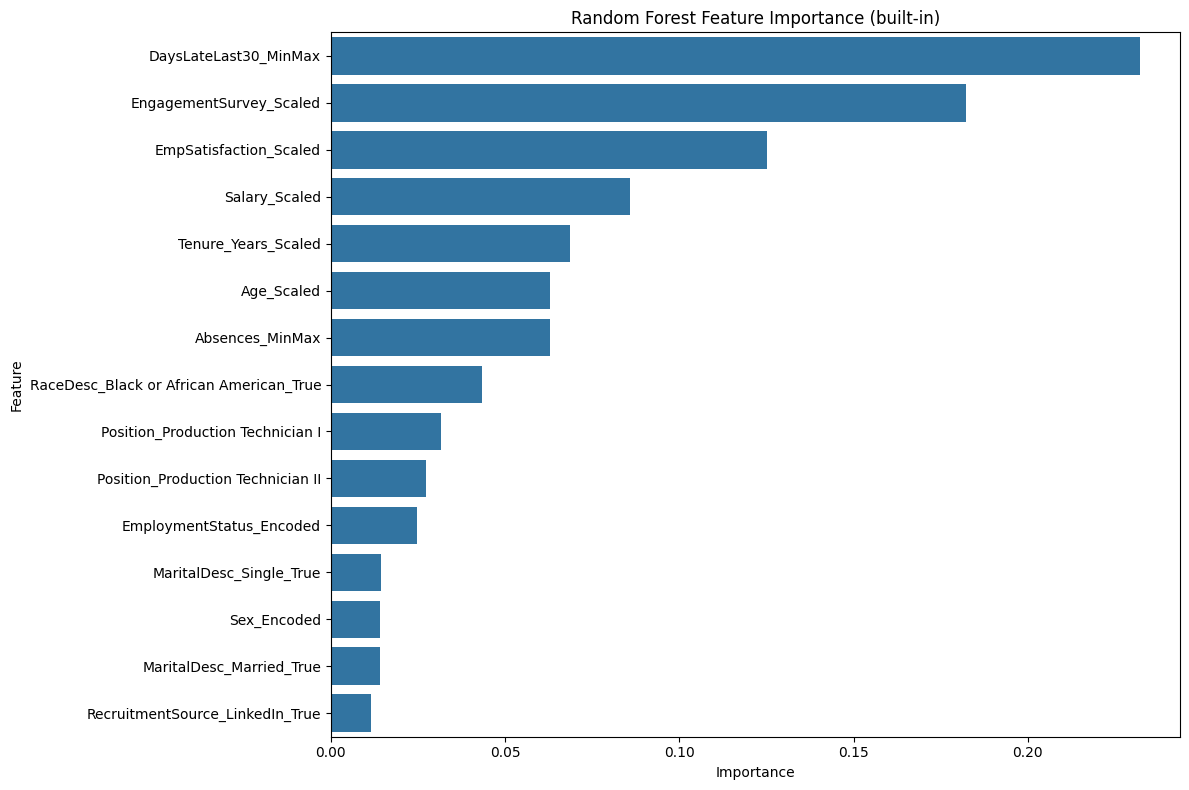


Top 10 features by built-in Random Forest importance:
                                    Feature  Importance
0                     DaysLateLast30_MinMax    0.232044
1                   EngagementSurvey_Scaled    0.182131
5                    EmpSatisfaction_Scaled    0.125180
4                             Salary_Scaled    0.085687
2                       Tenure_Years_Scaled    0.068486
6                                Age_Scaled    0.062778
3                           Absences_MinMax    0.062754
12  RaceDesc_Black or African American_True    0.043420
9          Position_Production Technician I    0.031488
10        Position_Production Technician II    0.027190
Error creating importance comparison: Per-column arrays must each be 1-dimensional

Random Forest SHAP analysis completed for Employee Dataset.


In [ ]:
# =====================
# SHAP Analysis for Employee Dataset Random Forest Model
# =====================
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle

print("\nPerforming SHAP analysis for Employee Dataset Random Forest model...")

# Load the saved model (if needed)
try:
    # Load from pickle file if needed
    # with open('rf_employee_model.pkl', 'rb') as file:
    #     best_model = pickle.load(file)
    # Assuming best_model is already available from previous code

    # Print the model information
    print(f"Model type: {type(best_model).__name__}")
    print(f"Pipeline steps: {best_model.named_steps.keys()}")
except Exception as e:
    print(f"Error loading or accessing model: {e}")


# For Random Forest, we can use TreeExplainer which is more efficient than KernelExplainer
try:
    print("Initializing TreeExplainer for Random Forest model...")

    # Get the underlying Random Forest model from the pipeline
    # In the employee dataset code, the classifier step is named 'classifier'
    if hasattr(best_model, 'named_steps') and 'classifier' in best_model.named_steps:
        rf_model = best_model.named_steps['classifier']
        print(f"Found RandomForestClassifier in pipeline: {type(rf_model).__name__}")
    else:
        # If it's not in a pipeline, use the model directly
        rf_model = best_model
        print("Using model directly without pipeline")

    # Get the preprocessor to transform data for SHAP analysis
    preprocessor = best_model.named_steps['preprocessor']

    # Extract feature names from the fitted preprocessor
    feature_names = []
    for name, transformer, columns in preprocessor.transformers_:
        if name == 'num':
            feature_names.extend(columns)
        elif name == 'cat':
            # Get the feature names from the fitted one-hot encoder
            feature_names.extend(transformer.get_feature_names_out(input_features=columns))

    print(f"Total transformed features: {len(feature_names)}")

    # Calculate SHAP values for a subset of the test data (for efficiency)
    if len(X_test) > 100:
        if hasattr(X_test, 'sample'):  # It's a DataFrame
            X_sample = X_test.sample(100, random_state=42)
        else:  # It's a NumPy array
            indices = np.random.RandomState(42).choice(X_test.shape[0], 100, replace=False)
            X_sample = X_test[indices]
    else:
        X_sample = X_test

    # Transform the data with the preprocessor
    X_shap = preprocessor.transform(X_sample)
    print(f"Transformed X_shap shape: {X_shap.shape}")

    # Initialize the SHAP explainer for the Random Forest model
    explainer = shap.TreeExplainer(rf_model)

    # For multi-class models, we get a list of SHAP value arrays (one per class)
    # For binary classification, we can get a single array of SHAP values
    shap_values = explainer.shap_values(X_shap)

    # Number of classes detected
    if isinstance(shap_values, list):
        n_classes = len(shap_values)
        print(f"Number of classes detected: {n_classes}")
    else:
        # Binary classification with TreeExplainer sometimes returns a single array
        n_classes = 2
        print(f"Binary classification detected")

    # Calculate average absolute SHAP values for feature importance
    if isinstance(shap_values, list):
        # Multi-class case
        overall_importance = np.zeros(X.shape[1])
        for i in range(n_classes):
            overall_importance += np.abs(shap_values[i]).mean(0)
    else:
        # Binary classification case with single array
        overall_importance = np.abs(shap_values).mean(0)

    # Create feature importance DataFrame with the transformed feature names
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'SHAP_Importance': overall_importance
    })
    feature_importance = feature_importance.sort_values('SHAP_Importance', ascending=False)

    print("\nTop 10 most important features according to SHAP:")
    print(feature_importance.head(10))

    # Create visualizations
    # 1. Summary plot for all classes
    plt.figure(figsize=(12, 8))
    if isinstance(shap_values, list):
        # Multi-class case
        shap.summary_plot(shap_values, X_shap, feature_names=feature_names, show=False)
    else:
        # Binary classification with single array
        shap.summary_plot(shap_values, X_shap, feature_names=feature_names, show=False)
    plt.title('SHAP Summary Plot (Random Forest)')
    plt.tight_layout()
    plt.savefig('rf_shap_summary.png')
    plt.show()

    # 2. Bar plot for overall feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='SHAP_Importance', y='Feature', data=feature_importance.head(15))
    plt.title('SHAP Feature Importance (Random Forest)')
    plt.tight_layout()
    plt.savefig('rf_shap_importance_barplot.png')
    plt.show()

    # 3. Dependence plots for top 3 features
    if isinstance(shap_values, list):
        # Multi-class - use the class with highest average predicted probability
        proba = rf_model.predict_proba(X_shap)
        avg_proba = proba.mean(axis=0)
        class_for_plots = np.argmax(avg_proba)
        print(f"Using class {class_for_plots} for dependence plots")

        # Create dependence plots for top 3 features
        for feature in feature_importance.head(3)['Feature'].values:
            feature_idx = feature_names.index(feature)
            plt.figure(figsize=(10, 6))
            shap.dependence_plot(
                feature_idx,
                shap_values[class_for_plots],
                X_shap,
                feature_names=feature_names,
                show=False
            )
            plt.title(f'SHAP Dependence Plot - {feature}')
            plt.tight_layout()
            # Clean filename by removing special characters
            safe_feature_name = ''.join(c if c.isalnum() else '_' for c in feature)
            plt.savefig(f'rf_shap_dependence_{safe_feature_name}.png')
            plt.show()
    else:
        # Binary classification with single array
        for feature in feature_importance.head(3)['Feature'].values:
            feature_idx = feature_names.index(feature)
            plt.figure(figsize=(10, 6))
            shap.dependence_plot(
                feature_idx,
                shap_values,
                X_shap,
                feature_names=feature_names,
                show=False
            )
            plt.title(f'SHAP Dependence Plot - {feature}')
            plt.tight_layout()
            # Clean filename by removing special characters
            safe_feature_name = ''.join(c if c.isalnum() else '_' for c in feature)
            plt.savefig(f'rf_shap_dependence_{safe_feature_name}.png')
            plt.show()

    # 4. Force plots for sample predictions
    print("\nCreating SHAP force plots for sample predictions...")

    # Select a few samples with different predictions
    n_samples = min(5, len(X_shap))
    sample_indices = np.random.choice(len(X_shap), n_samples, replace=False)

    for i, idx in enumerate(sample_indices):
        # Get slice of preprocessed data
        sample = X_shap[idx:idx+1]

        # Get the original sample for reference
        original_sample = X_sample.iloc[idx:idx+1] if hasattr(X_sample, 'iloc') else X_sample[idx:idx+1]

        # Get prediction
        pred_class = rf_model.predict(sample)[0]

        plt.figure(figsize=(14, 4))

        if isinstance(shap_values, list):
            # Multi-class case
            pred_class_idx = np.where(rf_model.classes_ == pred_class)[0][0]
            shap.force_plot(
                explainer.expected_value[pred_class_idx],
                shap_values[pred_class_idx][idx],
                pd.DataFrame(sample, columns=feature_names),
                feature_names=feature_names,
                matplotlib=True,
                show=False
            )
        else:
            # Binary classification with single array
            shap.force_plot(
                explainer.expected_value,
                shap_values[idx],
                pd.DataFrame(sample, columns=feature_names),
                feature_names=feature_names,
                matplotlib=True,
                show=False
            )

        plt.title(f'SHAP Force Plot for Sample {i+1} (Predicted Class: {pred_class})')
        plt.tight_layout()
        plt.savefig(f'rf_shap_force_plot_sample_{i+1}.png')
        plt.show()

        # Also print the top 5 contributors for this prediction
        if isinstance(shap_values, list):
            # Multi-class case
            feature_contribution = pd.DataFrame({
                'Feature': feature_names,
                'SHAP_Value': shap_values[pred_class_idx][idx]
            })
        else:
            # Binary classification with single array
            feature_contribution = pd.DataFrame({
                'Feature': feature_names,
                'SHAP_Value': shap_values[idx]
            })

        feature_contribution['AbsValue'] = np.abs(feature_contribution['SHAP_Value'])
        feature_contribution = feature_contribution.sort_values('AbsValue', ascending=False)

        print(f"\nTop 5 contributors for Sample {i+1} (Predicted Class: {pred_class}):")
        for _, row in feature_contribution.head(5).iterrows():
            direction = "increases" if row['SHAP_Value'] > 0 else "decreases"
            print(f"  {row['Feature']}: {row['SHAP_Value']:.4f} ({direction} prediction)")

except Exception as e:
    print(f"Error in main SHAP analysis for Random Forest: {e}")

    # Fall back to built-in feature importance for Random Forest
    try:
        print("\nFalling back to built-in Random Forest feature importance...")

        # Extract feature importance from the Random Forest model
        if hasattr(best_model, 'named_steps') and 'classifier' in best_model.named_steps:
            importance = best_model.named_steps['classifier'].feature_importances_
        else:
            importance = best_model.feature_importances_

        # Get feature names from preprocessor
        feature_names = []
        preprocessor = best_model.named_steps['preprocessor']
        for name, transformer, columns in preprocessor.transformers_:
            if name == 'num':
                feature_names.extend(columns)
            elif name == 'cat':
                feature_names.extend(transformer.get_feature_names_out(input_features=columns))

        # Create DataFrame for feature importance
        feature_imp_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        }).sort_values('Importance', ascending=False)

        # Plot feature importance
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(15))
        plt.title('Random Forest Feature Importance (built-in)')
        plt.tight_layout()
        plt.savefig('rf_builtin_importance.png')
        plt.show()

        print("\nTop 10 features by built-in Random Forest importance:")
        print(feature_imp_df.head(10))

    except Exception as e2:
        print(f"Error extracting Random Forest feature importance: {e2}")

# Optional: Compare SHAP importances with built-in feature importances
try:
    rf_importances = rf_model.feature_importances_

    # Create a comparison DataFrame
    comparison_df = pd.DataFrame({
        'Feature': feature_names,
        'SHAP_Importance': overall_importance,
        'RF_Importance': rf_importances
    })

    # Normalize both importance metrics to sum to 1 for fair comparison
    comparison_df['SHAP_Importance_Norm'] = comparison_df['SHAP_Importance'] / comparison_df['SHAP_Importance'].sum()
    comparison_df['RF_Importance_Norm'] = comparison_df['RF_Importance'] / comparison_df['RF_Importance'].sum()

    # Sort by SHAP importance
    comparison_df = comparison_df.sort_values('SHAP_Importance_Norm', ascending=False).head(15)

    # Plot comparison
    plt.figure(figsize=(14, 10))

    # Reshape for seaborn
    plot_df = pd.melt(comparison_df,
                      id_vars=['Feature'],
                      value_vars=['SHAP_Importance_Norm', 'RF_Importance_Norm'],
                      var_name='Method', value_name='Importance')

    sns.barplot(x='Importance', y='Feature', hue='Method', data=plot_df)
    plt.title('Feature Importance: SHAP vs. Built-in Random Forest')
    plt.tight_layout()
    plt.savefig('rf_importance_comparison.png')
    plt.show()

    print("\nComparison between SHAP and built-in feature importance completed.")
except Exception as e:
    print(f"Error creating importance comparison: {e}")

print("\nRandom Forest SHAP analysis completed for Employee Dataset.")


Performing SHAP analysis for Employee Dataset Random Forest model...
Found RandomForestClassifier: RandomForestClassifier
Found preprocessor: ColumnTransformer
Numerical columns: 11
Categorical columns: 4
Total transformed features: 15

Top 10 features by RandomForest importance:
                                    Feature  Importance
0                     DaysLateLast30_MinMax    0.232044
1                   EngagementSurvey_Scaled    0.182131
5                    EmpSatisfaction_Scaled    0.125180
4                             Salary_Scaled    0.085687
2                       Tenure_Years_Scaled    0.068486
6                                Age_Scaled    0.062778
3                           Absences_MinMax    0.062754
12  RaceDesc_Black or African American_True    0.043420
9          Position_Production Technician I    0.031488
10        Position_Production Technician II    0.027190

Number of classes: 4
Class labels: [1 2 3 4]

Using KernelExplainer (alternative to TreeExplainer)...

  0%|          | 0/20 [00:00<?, ?it/s]

<Figure size 1200x800 with 0 Axes>

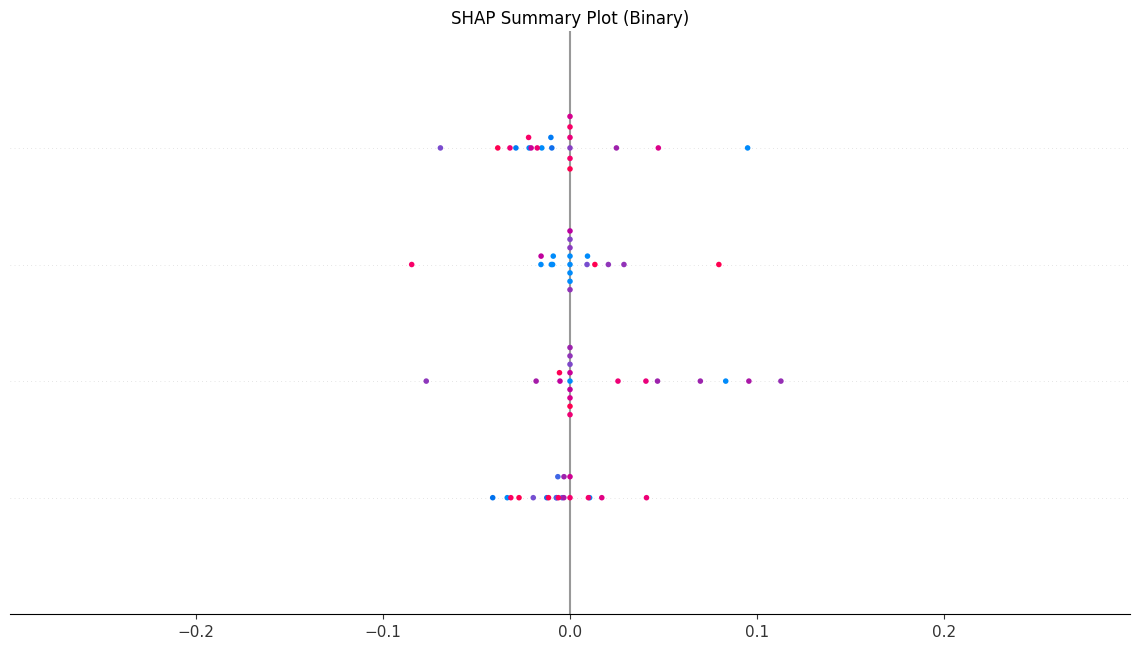


Calculating permutation importance as an alternative...


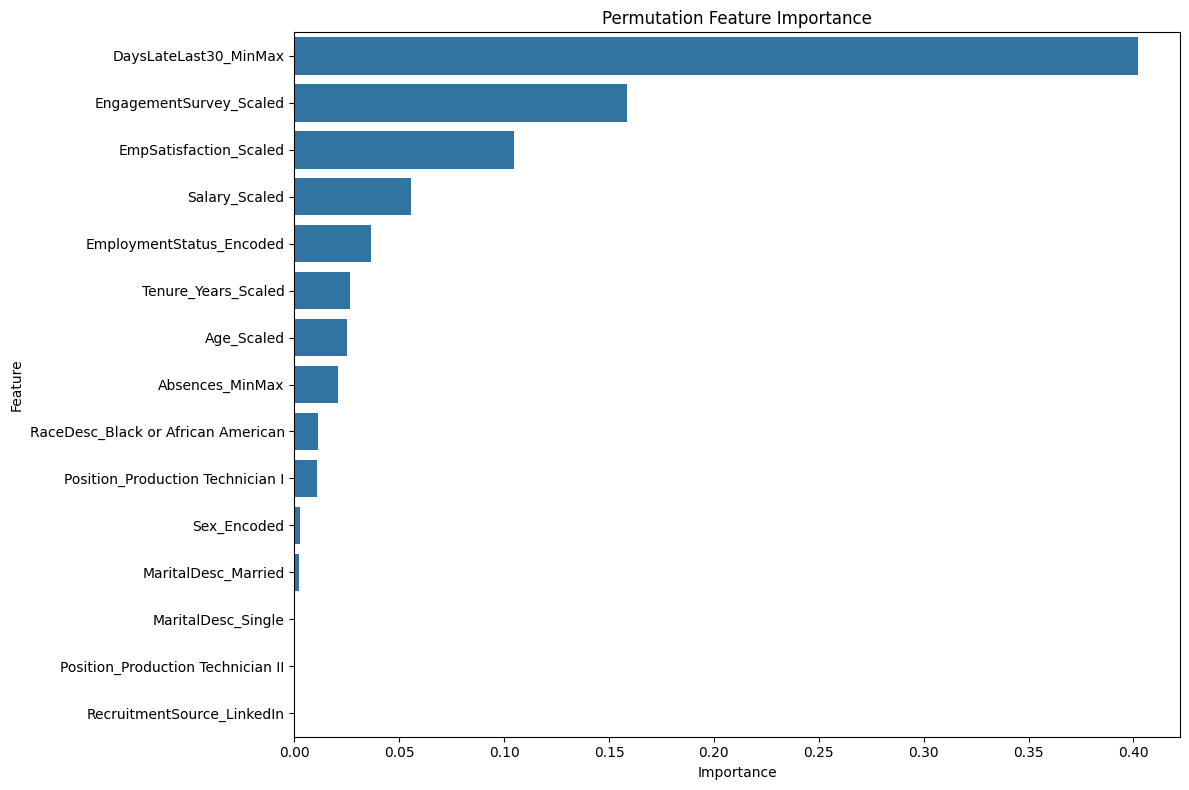


Top 10 features by permutation importance:
                               Feature  Importance       Std
0                DaysLateLast30_MinMax    0.402083  0.024957
1              EngagementSurvey_Scaled    0.158333  0.015485
5               EmpSatisfaction_Scaled    0.104688  0.013062
4                        Salary_Scaled    0.055729  0.010687
7             EmploymentStatus_Encoded    0.036458  0.012758
2                  Tenure_Years_Scaled    0.026562  0.008854
6                           Age_Scaled    0.025000  0.008333
3                      Absences_MinMax    0.020833  0.005208
10  RaceDesc_Black or African American    0.011458  0.005103
12    Position_Production Technician I    0.010937  0.005916

Comparing feature importance methods...


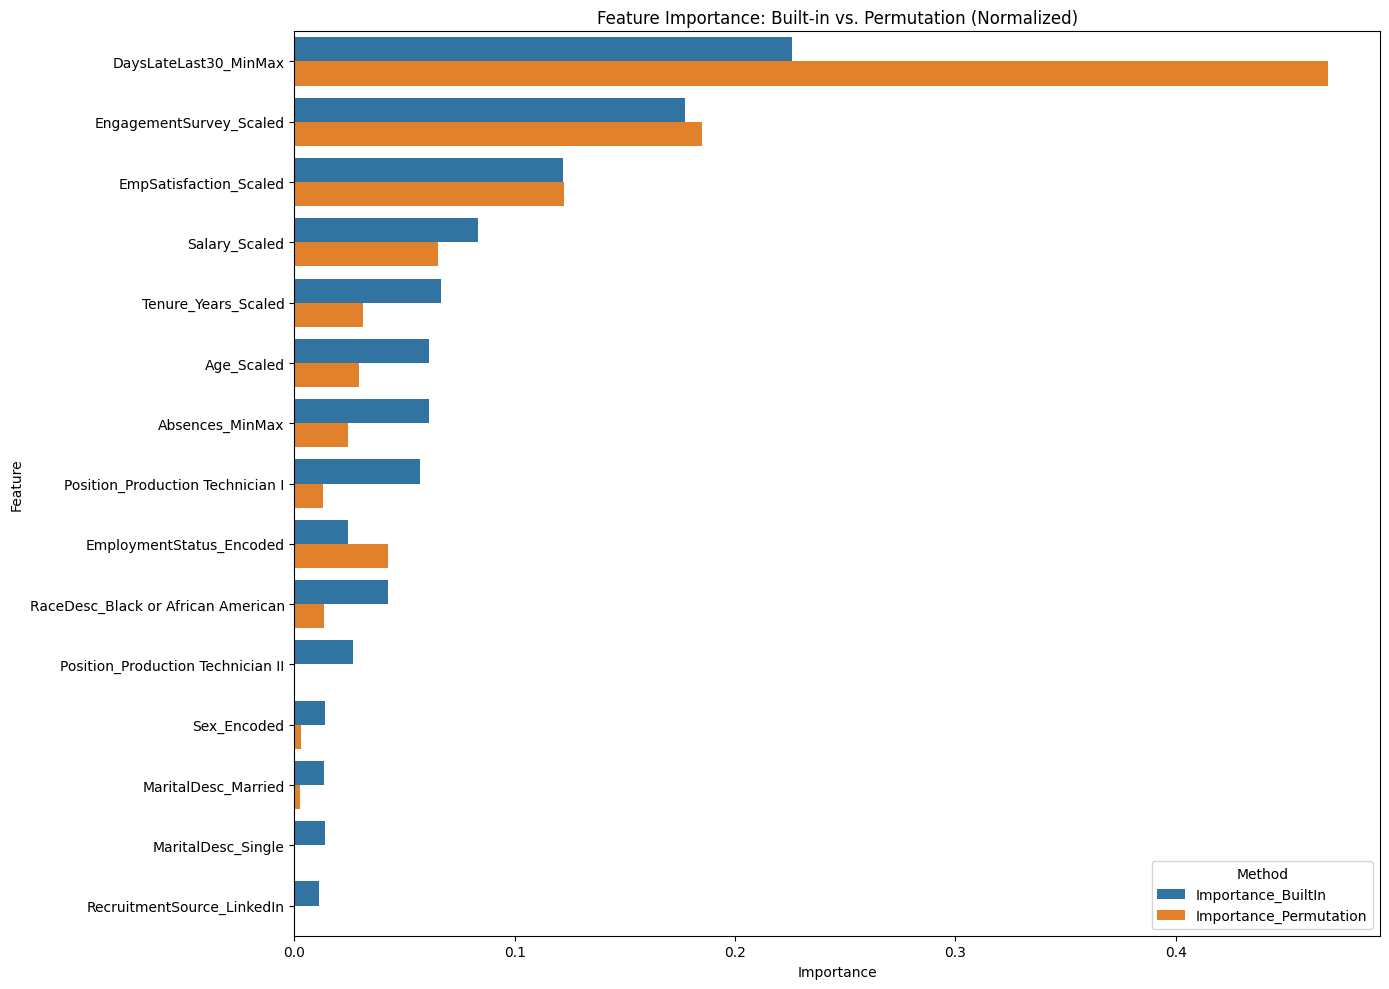


Feature importance methods comparison completed.

Random Forest analysis completed for Employee Dataset.


In [ ]:
# =====================
# SHAP Analysis for Employee Dataset Random Forest Model - FIXED
# =====================
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle

print("\nPerforming SHAP analysis for Employee Dataset Random Forest model...")

# Extract the model and preprocessor
try:
    # Access the underlying Random Forest classifier
    rf_model = best_model.named_steps['classifier']
    print(f"Found RandomForestClassifier: {type(rf_model).__name__}")

    # Access the preprocessor
    preprocessor = best_model.named_steps['preprocessor']
    print(f"Found preprocessor: {type(preprocessor).__name__}")

    # Get preprocessed feature names
    num_cols = [col for col in X.select_dtypes(include=['int64', 'float64']).columns]
    cat_cols = [col for col in X.select_dtypes(include=['bool', 'object']).columns]

    print(f"Numerical columns: {len(num_cols)}")
    print(f"Categorical columns: {len(cat_cols)}")

    # Get feature names after preprocessing
    feature_names = []
    for name, transformer, columns in preprocessor.transformers_:
        if name == 'num':
            feature_names.extend(columns)
        elif name == 'cat':
            try:
                # Get one-hot encoded feature names
                feature_names.extend(transformer.get_feature_names_out(input_features=columns))
            except:
                # Fallback for older sklearn versions
                for col in columns:
                    feature_names.append(f"{col}_encoded")

    print(f"Total transformed features: {len(feature_names)}")

    # Sample subset of data for analysis
    if len(X_test) > 100:
        X_sample = X_test.sample(100, random_state=42)
    else:
        X_sample = X_test

    # Get the raw feature importance from Random Forest
    importances = rf_model.feature_importances_

    # Create a DataFrame with feature importances
    feature_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print("\nTop 10 features by RandomForest importance:")
    print(feature_imp_df.head(10))

    # Get the classes from the model
    classes = rf_model.classes_
    n_classes = len(classes)
    print(f"\nNumber of classes: {n_classes}")
    print(f"Class labels: {classes}")

    # Try KernelExplainer as an alternative to TreeExplainer
    try:
        print("\nUsing KernelExplainer (alternative to TreeExplainer)...")

        # Create background dataset (first transform X_train)
        X_train_sample = X_train.sample(min(100, len(X_train)), random_state=42)
        X_background = preprocessor.transform(X_train_sample)

        # Create a prediction function for SHAP
        def predict_fn(x):
            return rf_model.predict_proba(x)

        # Initialize KernelExplainer
        explainer = shap.KernelExplainer(predict_fn, X_background)

        # Transform test data
        X_shap = preprocessor.transform(X_sample)

        # Calculate SHAP values for each class
        # For efficiency, use just a few samples
        small_sample = X_shap[:20]  # Use only 20 samples for faster computation
        shap_values = explainer.shap_values(small_sample)

        # Check if shap_values is a list (multiple classes)
        if isinstance(shap_values, list):
            print(f"Got SHAP values for {len(shap_values)} classes")

            # Create summary plot for all classes
            plt.figure(figsize=(12, 8))
            shap.summary_plot(
                shap_values,
                small_sample,
                feature_names=feature_names,
                show=False
            )
            plt.title('SHAP Summary Plot (All Classes)')
            plt.tight_layout()
            plt.savefig('rf_shap_summary_all.png')
            plt.show()

            # Create summary plots for each class
            for i, class_label in enumerate(classes):
                plt.figure(figsize=(12, 8))
                shap.summary_plot(
                    shap_values[i],
                    small_sample,
                    feature_names=feature_names,
                    plot_type='bar',
                    show=False
                )
                plt.title(f'SHAP Feature Importance for Performance Score {class_label}')
                plt.tight_layout()
                plt.savefig(f'rf_shap_importance_class{class_label}.png')
                plt.show()

                # Get top 5 features for this class
                class_importances = pd.DataFrame({
                    'Feature': feature_names,
                    'SHAP_Value': np.abs(shap_values[i]).mean(0)
                }).sort_values('SHAP_Value', ascending=False)

                print(f"\nTop 5 features for Performance Score {class_label}:")
                print(class_importances.head(5))

                # Force plot for one example (first sample)
                plt.figure(figsize=(20, 3))
                shap.force_plot(
                    explainer.expected_value[i],
                    shap_values[i][0],
                    feature_names=feature_names,
                    matplotlib=True,
                    show=False
                )
                plt.title(f'SHAP Force Plot for Performance Score {class_label}')
                plt.tight_layout()
                plt.savefig(f'rf_shap_force_class{class_label}.png')
                plt.show()
        else:
            # Binary case
            plt.figure(figsize=(12, 8))
            shap.summary_plot(
                shap_values,
                small_sample,
                feature_names=feature_names,
                show=False
            )
            plt.title('SHAP Summary Plot (Binary)')
            plt.tight_layout()
            plt.savefig('rf_shap_summary_binary.png')
            plt.show()

    except Exception as e:
        print(f"Error using KernelExplainer: {e}")

    # Alternative: Use permutation importance
    try:
        print("\nCalculating permutation importance as an alternative...")
        from sklearn.inspection import permutation_importance

        # Calculate permutation importance
        perm_importance = permutation_importance(
            best_model, X_test, y_test,
            n_repeats=10,
            random_state=42
        )

        # Create DataFrame for visualization
        perm_imp_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': perm_importance.importances_mean,
            'Std': perm_importance.importances_std
        }).sort_values('Importance', ascending=False)

        # Plot permutation importance
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=perm_imp_df.head(15))
        plt.title('Permutation Feature Importance')
        plt.tight_layout()
        plt.savefig('rf_permutation_importance.png')
        plt.show()

        print("\nTop 10 features by permutation importance:")
        print(perm_imp_df.head(10))

    except Exception as e:
        print(f"Error calculating permutation importance: {e}")

    # Compare feature importances from different methods
    try:
        print("\nComparing feature importance methods...")

        # Get built-in importances for original features
        builtin_imp = pd.DataFrame({
            'Feature': X.columns,
            'Importance': np.zeros(len(X.columns))
        })

        # Map transformed feature importances back to original features
        for i, feature in enumerate(feature_names):
            for orig_feature in X.columns:
                if orig_feature in feature:
                    # Add importance to the original feature
                    builtin_imp.loc[builtin_imp['Feature'] == orig_feature, 'Importance'] += importances[i]

        # Sort by importance
        builtin_imp = builtin_imp.sort_values('Importance', ascending=False)

        # Plot comparison with permutation importance if available
        if 'perm_imp_df' in locals():
            # Join the two dataframes
            comparison = pd.merge(
                builtin_imp,
                perm_imp_df[['Feature', 'Importance']],
                on='Feature',
                suffixes=('_BuiltIn', '_Permutation')
            )

            # Normalize values for fair comparison
            comparison['Importance_BuiltIn'] = comparison['Importance_BuiltIn'] / comparison['Importance_BuiltIn'].sum()
            comparison['Importance_Permutation'] = comparison['Importance_Permutation'] / comparison['Importance_Permutation'].sum()

            # Sort by the average importance
            comparison['Avg_Importance'] = (comparison['Importance_BuiltIn'] + comparison['Importance_Permutation']) / 2
            comparison = comparison.sort_values('Avg_Importance', ascending=False).head(15)

            # Plot comparison
            plt.figure(figsize=(14, 10))

            # Reshape for seaborn
            plot_df = pd.melt(
                comparison,
                id_vars=['Feature'],
                value_vars=['Importance_BuiltIn', 'Importance_Permutation'],
                var_name='Method',
                value_name='Importance'
            )

            sns.barplot(x='Importance', y='Feature', hue='Method', data=plot_df)
            plt.title('Feature Importance: Built-in vs. Permutation (Normalized)')
            plt.tight_layout()
            plt.savefig('rf_importance_method_comparison.png')
            plt.show()

            print("\nFeature importance methods comparison completed.")

    except Exception as e:
        print(f"Error comparing feature importances: {e}")

except Exception as e:
    print(f"General error in SHAP analysis: {e}")

print("\nRandom Forest analysis completed for Employee Dataset.")

In [ ]:
# =====================
# Class-by-Class SHAP Analysis for Employee Dataset
# =====================
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

print("\nPerforming Class-by-Class SHAP Analysis for Employee Performance Model...")

try:
    # Extract the Random Forest model and preprocessor
    rf_model = best_model.named_steps['classifier']
    preprocessor = best_model.named_steps['preprocessor']

    # Get the class labels
    classes = rf_model.classes_
    print(f"Performance Score Classes: {classes}")

    # Sample subset of data for analysis
    if len(X_test) > 100:
        X_sample = X_test.sample(100, random_state=42)
        y_sample = y_test.loc[X_sample.index]
    else:
        X_sample = X_test
        y_sample = y_test

    # Transform data for SHAP analysis
    X_transformed = preprocessor.transform(X_sample)

    # Get feature names after preprocessing
    feature_names = []
    for name, transformer, columns in preprocessor.transformers_:
        if name == 'num':
            feature_names.extend(columns)
        elif name == 'cat':
            try:
                feature_names.extend(transformer.get_feature_names_out(input_features=columns))
            except:
                # Fallback for older sklearn versions
                for col in columns:
                    feature_names.append(f"{col}_encoded")

    print(f"Total transformed features: {len(feature_names)}")

    # Function for creating prediction function for a specific class
    def predict_class_proba(class_idx):
        def predict_fn(X):
            return rf_model.predict_proba(X)[:, class_idx]
        return predict_fn

    # Create background dataset
    X_train_sample = X_train.sample(min(100, len(X_train)), random_state=42)
    X_background = preprocessor.transform(X_train_sample)

    # For each class, perform a separate SHAP analysis
    for class_idx, class_label in enumerate(classes):
        print(f"\n{'='*30}")
        print(f"ANALYZING PERFORMANCE SCORE {class_label}")
        print(f"{'='*30}")

        # Create a prediction function for this specific class
        predict_fn = predict_class_proba(class_idx)

        # Initialize KernelExplainer for this class
        print(f"Initializing KernelExplainer for Performance Score {class_label}...")
        explainer = shap.KernelExplainer(predict_fn, X_background)

        # Calculate SHAP values for this class (use fewer samples for speed)
        small_sample = X_transformed[:20]  # Use just 20 samples for faster computation
        shap_values = explainer.shap_values(small_sample)

        print(f"SHAP values shape for class {class_label}: {np.array(shap_values).shape}")

        # 1. Summary plot (bar plot) for this class
        plt.figure(figsize=(12, 8))
        shap.summary_plot(
            shap_values,
            small_sample,
            feature_names=feature_names,
            plot_type='bar',
            show=False
        )
        plt.title(f'Feature Importance for Performance Score {class_label}')
        plt.tight_layout()
        plt.savefig(f'shap_importance_class{class_label}.png')
        plt.show()

        # 2. Summary plot (beeswarm) for this class
        plt.figure(figsize=(12, 8))
        shap.summary_plot(
            shap_values,
            small_sample,
            feature_names=feature_names,
            show=False
        )
        plt.title(f'Feature Impact for Performance Score {class_label}')
        plt.tight_layout()
        plt.savefig(f'shap_beeswarm_class{class_label}.png')
        plt.show()

        # 3. Get top features for this class
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'SHAP_Value': np.abs(shap_values).mean(0)
        }).sort_values('SHAP_Value', ascending=False)

        print(f"\nTop 10 features for Performance Score {class_label}:")
        print(feature_importance.head(10))

        # 4. Dependence plots for top features
        top_features = feature_importance.head(5)['Feature'].values
        for feature in top_features:
            feature_idx = list(feature_names).index(feature)
            plt.figure(figsize=(10, 6))
            shap.dependence_plot(
                feature_idx,
                shap_values,
                small_sample,
                feature_names=feature_names,
                show=False
            )
            plt.title(f'SHAP Dependence Plot - {feature} (Performance Score {class_label})')
            plt.tight_layout()
            # Clean feature name for filename
            safe_feature = ''.join(c if c.isalnum() else '_' for c in feature)
            plt.savefig(f'shap_dependence_class{class_label}_{safe_feature}.png')
            plt.show()

        # 5. Force plots for individual samples
        # Find samples that were predicted as this class
        predictions = rf_model.predict(X_transformed)
        sample_indices = np.where(predictions == class_label)[0][:3]  # Take up to 3 examples

        for i, idx in enumerate(sample_indices):
            if idx < len(small_sample):
                plt.figure(figsize=(20, 3))
                shap.force_plot(
                    explainer.expected_value,
                    shap_values[idx],
                    features=small_sample[idx],
                    feature_names=feature_names,
                    matplotlib=True,
                    show=False
                )
                plt.title(f'SHAP Force Plot - Sample {i+1} (Performance Score {class_label})')
                plt.tight_layout()
                plt.savefig(f'shap_force_class{class_label}_sample{i+1}.png')
                plt.show()

    # Compare top features across classes
    print("\nComparing top features across performance score classes...")

    # Get importance for each class and compile into one DataFrame
    class_importance = {}

    for class_idx, class_label in enumerate(classes):
        # Create prediction function for this class
        predict_fn = predict_class_proba(class_idx)

        # Initialize explainer
        explainer = shap.KernelExplainer(predict_fn, X_background)

        # Get SHAP values
        shap_values = explainer.shap_values(small_sample)

        # Calculate mean absolute SHAP value for each feature
        class_importance[class_label] = np.abs(shap_values).mean(0)

    # Create DataFrame with feature importances for all classes
    comparison_df = pd.DataFrame({
        'Feature': feature_names
    })

    # Add importance for each class
    for class_label in classes:
        comparison_df[f'Class_{class_label}'] = class_importance[class_label]

    # Add overall importance (average across classes)
    comparison_df['Overall'] = comparison_df[[f'Class_{cl}' for cl in classes]].mean(axis=1)

    # Sort by overall importance
    comparison_df = comparison_df.sort_values('Overall', ascending=False).head(15)

    # Create a heatmap to visualize importance across classes
    plt.figure(figsize=(12, 10))

    # Prepare data for heatmap
    heatmap_data = comparison_df.set_index('Feature')[[f'Class_{cl}' for cl in classes]]

    # Normalize values for better visualization
    normalized_data = heatmap_data.div(heatmap_data.max(axis=1), axis=0)

    # Rename columns for better display
    normalized_data.columns = [f'Score {cl}' for cl in classes]

    # Generate heatmap
    sns.heatmap(normalized_data, cmap='Blues', annot=True, fmt='.2f')
    plt.title('Feature Importance Across Performance Score Classes (Normalized)')
    plt.tight_layout()
    plt.savefig('shap_class_importance_heatmap.png')
    plt.show()

    # Create bar chart comparison
    plt.figure(figsize=(14, 10))

    # Reshape for plotting
    plot_df = pd.melt(
        comparison_df,
        id_vars=['Feature'],
        value_vars=[f'Class_{cl}' for cl in classes],
        var_name='Performance_Score',
        value_name='SHAP_Importance'
    )

    # Clean up labels
    plot_df['Performance_Score'] = plot_df['Performance_Score'].apply(lambda x: f"Score {x.split('_')[1]}")

    # Create grouped bar chart
    sns.barplot(x='SHAP_Importance', y='Feature', hue='Performance_Score', data=plot_df)
    plt.title('Feature Importance Comparison Across Performance Scores')
    plt.tight_layout()
    plt.savefig('shap_class_importance_comparison.png')
    plt.show()

except Exception as e:
    print(f"Error in class-by-class SHAP analysis: {e}")

    # Fallback to permutation importance by class
    try:
        print("\nFalling back to permutation importance by class...")

        # One-vs-Rest permutation importance for each class
        for class_label in rf_model.classes_:
            # Create binary target (this class vs others)
            y_binary = (y_test == class_label).astype(int)

            # Calculate permutation importance
            perm_importance = permutation_importance(
                best_model, X_test, y_binary,
                n_repeats=10,
                random_state=42
            )

            # Create DataFrame
            perm_imp_df = pd.DataFrame({
                'Feature': X.columns,
                'Importance': perm_importance.importances_mean,
                'Std': perm_importance.importances_std
            }).sort_values('Importance', ascending=False)

            # Plot
            plt.figure(figsize=(12, 8))
            sns.barplot(x='Importance', y='Feature', data=perm_imp_df.head(15))
            plt.title(f'Permutation Importance for Performance Score {class_label}')
            plt.tight_layout()
            plt.savefig(f'permutation_importance_class{class_label}.png')
            plt.show()

            print(f"\nTop 10 features for Performance Score {class_label} (Permutation Importance):")
            print(perm_imp_df.head(10))

    except Exception as e2:
        print(f"Error in permutation importance analysis: {e2}")

print("\nClass-by-class feature importance analysis completed.")

Output hidden; open in https://colab.research.google.com to view.